<a href="https://colab.research.google.com/github/SEOUL-ABSS/SHIPSHIP/blob/main/SONAR7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ShipsEar — Part 1 v3.3 (Colab, hardened + Exhibits)
# - Colab-ready, single-cell script
# - Zero-shot v0a (YAMNet ship-score)
# - Emb / FT models (v0b, v5, v6, v7, v8)
# - XAI: time/freq occlusion + global band importance
# - Exhibits: spec + time–freq importance overlays for best MLP model
# - Robust device_summary (no tf-name collisions)
# - Saves per-version test predictions for Part 2

print("Setup…")
!pip -q install "tensorflow==2.19.0" tensorflow_hub==0.16.1 librosa==0.10.2.post1 soundfile==0.12.1 scikit-learn==1.5.2 psutil==5.9.8 seaborn==0.13.2 joblib==1.4.2
!apt -yq install fonts-nanum >/dev/null

# ----------------------------------------------------------------------
# Imports
# ----------------------------------------------------------------------
import os, re, random, math, time, json, glob, shutil, warnings, platform
from collections import Counter, defaultdict, OrderedDict

import numpy as np, pandas as pd, psutil, soundfile as sf
import tensorflow as tf, tensorflow_hub as hub, librosa
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt, seaborn as sns, matplotlib.font_manager as fm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix as CM,
    f1_score as F1,
    roc_auc_score as AUC,
    average_precision_score as AP,
    balanced_accuracy_score as BACC,
    top_k_accuracy_score as TOPK,
    accuracy_score as ACC,
)
from sklearn.model_selection import GroupShuffleSplit

import scipy as sp
import scipy.signal as sig

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------------------------------------------------
# Seeds / TF setup / Fonts
# ----------------------------------------------------------------------
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

try:
    for g in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass

mixed_precision.set_global_policy("mixed_float16")

if os.path.exists('/usr/share/fonts/truetype/nanum/NanumGothic.ttf'):
    fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
    plt.rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False


def mem():
    return f"{psutil.Process().memory_info().rss/1024**3:.2f} GB"


# Robust device summary (no reliance on global tf/hub names)
# This avoids errors when someone overwrites tf with a tensor later.

def device_summary():
    import tensorflow as tf_mod
    import tensorflow_hub as hub_mod
    import librosa as librosa_mod
    import scipy as sp_mod
    import platform as plat_mod

    try:
        gpus = tf_mod.config.experimental.list_physical_devices('GPU')
        cpus = tf_mod.config.experimental.list_physical_devices('CPU')
        for g in gpus:
            try:
                tf_mod.config.experimental.set_memory_growth(g, True)
            except Exception:
                pass
    except Exception:
        gpus, cpus = [], []

    return dict(
        tf=tf_mod.__version__,
        hub=hub_mod.__version__,
        librosa=librosa_mod.__version__,
        scipy=sp_mod.__version__,
        py=plat_mod.python_version(),
        gpus=len(gpus),
        cpus=len(cpus),
        gpu_names=[getattr(x, 'name', str(x)) for x in gpus],
    )


# ----------------------------------------------------------------------
# Paths / Config
# ----------------------------------------------------------------------
BASE = "/content"
SHIPSEAR_DRIVE = "/content/drive/MyDrive/ShipsEar"
SHIPSEAR = f"{BASE}/ShipsEar_colab"

os.makedirs("results/part1", exist_ok=True)
os.makedirs("cache", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)
os.makedirs("state", exist_ok=True)

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("Drive mounted.")
except Exception as e:
    print("Not Colab or Drive:", e)

YAM_SR = 16000
BINARY_MODE = True
POS_LABEL = "Ship"

CFG = dict(
    seg_dur=1.0,
    ship_overlap=0.2,
    noise_overlap=0.0,
    vad_frame_sec=0.5,
    vad_hop_sec=0.25,
    vad_top_db=25.0,
    test_size=0.2,
    epochs=40,
    batch=32,
    lr=5e-4,
    max_seg_per_group_per_class=500,
    noise_jitter_sec=0.5,
    topk=1,
    cache_emb=True,
)

# feature toggles
USE_MIXED = True
NORM_AUDIO = True
CACHE_RATIO = 1.0
FAST_SMOKE = False  # if True, fewer samples in global band importance

# exhibit settings (time–freq occlusion)
EX_T_PATCH = 20
EX_F_PATCH = 24
EX_N_SHIP = 4
EX_N_NOISE = 4

# versions
VERSIONS = [
    dict(name="v0a_yamnet_zeroshot", type="zero"),
    dict(name="v0b_emb_logreg_basic", type="emb", classifier="logreg", pooling="meanstd", aug=None),
    dict(name="v5_meanstd_mlp_aug",  type="emb", classifier="mlp",    pooling="meanstd", aug="light"),
    dict(name="v6_ft_mean_headonly", type="ft",  pooling="mean",      aug="light"),
    dict(name="v7_ft_meanstd_headonly", type="ft", pooling="meanstd", aug="light"),
    dict(name="v8_ft_meanstd_headonly_tinyLR", type="ft", pooling="meanstd", aug="light"),
]

# ----------------------------------------------------------------------
# Data copy
# ----------------------------------------------------------------------
print("Data…")
if os.path.exists(SHIPSEAR_DRIVE):
    if not os.path.exists(SHIPSEAR) or not os.listdir(SHIPSEAR):
        shutil.copytree(SHIPSEAR_DRIVE, SHIPSEAR, dirs_exist_ok=True)
        print(" - Copied ShipsEar")
    else:
        print(" - ShipsEar exists")
else:
    raise FileNotFoundError(f"ShipsEar drive not found: {SHIPSEAR_DRIVE}")


# ----------------------------------------------------------------------
# Label / group helpers
# ----------------------------------------------------------------------
KW = {
    "A": ["fishing", "trawler", "trawl", "mussel", "tug", "dredger", "dredge"],
    "B": ["motorboat", "motor boat", "pilot", "sailboat", "sailing"],
    "C": ["ferry", "passenger"],
    "D": ["oceanliner", "ocean liner", "ro-ro", "roro", "ro_ro", "cargo", "containership", "container", "tanker", "bulk", "liner", "oceangoing"],
    "E": ["background", "noise", "ambient", "no_ship", "noship", "silence"],
}


def resolve_class(path):
    txt = (os.path.basename(os.path.dirname(path)) + " " + os.path.basename(path)).lower()
    for c, kws in (("E", KW["E"]), ("A", KW["A"]), ("B", KW["B"]), ("C", KW["C"]), ("D", KW["D"])):
        if any(k in txt for k in kws):
            return c
    m = re.search(r"\bclass[_\s-]*([abcde])\b", txt)
    return m.group(1).upper() if m else None


def group_key(path):
    stem = os.path.splitext(os.path.basename(path))[0]
    m = re.search(r"(\d{8}[_-]?\d{4})", stem) or re.search(r"(\d{4}[-_]\d{2}[-_]\d{2}[_-]?\d{2}[-_]?\d{2})", stem)
    if m:
        return m.group(1)
    parent = os.path.basename(os.path.dirname(path))
    toks = re.split(r"[_\-]+", stem)
    pref = "_".join(toks[:3]) if len(toks) >= 3 else stem
    return f"{parent}:{pref}"


# ----------------------------------------------------------------------
# VAD / segment building
# ----------------------------------------------------------------------
EPS = 1e-12


def get_activity(file_path, top_db=25.0, frame_sec=0.5, hop_sec=0.25):
    try:
        with sf.SoundFile(file_path) as f:
            sr = f.samplerate
            n = len(f)
            F = max(1, int(frame_sec * sr))
            H = max(1, int(hop_sec * sr))

            # 1st pass: max dB
            max_db = -np.inf
            pos = 0
            while pos + F <= n:
                f.seek(pos)
                y = f.read(frames=F, dtype='float32', always_2d=False)
                y = y.mean(axis=1) if y.ndim > 1 else y
                rms = float(np.sqrt(np.mean(y**2)) + EPS)
                max_db = max(max_db, 20 * np.log10(rms + EPS))
                pos += H

            if not np.isfinite(max_db):
                return [], []

            th = max_db - top_db
            active = []
            in_act = False
            cur = 0.0
            pos = 0
            while pos + F <= n:
                f.seek(pos)
                y = f.read(frames=F, dtype='float32', always_2d=False)
                y = y.mean(axis=1) if y.ndim > 1 else y
                db = 20 * np.log10(float(np.sqrt(np.mean(y**2)) + EPS))
                t0 = pos / sr
                t1 = (pos + F) / sr
                if db >= th:
                    if not in_act:
                        in_act = True
                        cur = t0
                else:
                    if in_act:
                        in_act = False
                        active.append((cur, t1))
                pos += H
            if in_act:
                active.append((cur, n / sr))

            inactive = []
            last = 0.0
            dur = n / sr
            for s, e in active:
                if s > last:
                    inactive.append((last, s))
                last = e
            if last < dur:
                inactive.append((last, dur))
            return active, inactive
    except Exception:
        return [], []


def spans_to_segs(spans, seg_dur, hop):
    segs = []
    for s, e in spans:
        if e - s < seg_dur:
            continue
        st = s
        while st <= e - seg_dur + 1e-9:
            segs.append((float(st),))
            st += hop
    return segs


def build_segments(root, cfg):
    seg_dur = cfg["seg_dur"]
    hop_ship = seg_dur * (1 - cfg["ship_overlap"])
    hop_noise = seg_dur * (1 - cfg["noise_overlap"])
    noise_jitter = cfg["noise_jitter_sec"]
    cap = cfg["max_seg_per_group_per_class"]

    infos, labels, groups = [], [], []
    missing = 0
    per_gc = defaultdict(int)
    summary = defaultdict(int)

    for fp in glob.glob(os.path.join(root, "**", "*.wav"), recursive=True):
        c = resolve_class(fp)
        if c is None:
            missing += 1
            continue
        try:
            info = sf.info(fp)
        except Exception:
            continue
        gk = group_key(fp)

        if c in "ABCD":
            act, _ = get_activity(fp, cfg["vad_top_db"], cfg["vad_frame_sec"], cfg["vad_hop_sec"])
            spans = act
            hop = hop_ship
        else:
            dur = info.frames / info.samplerate
            spans = [(0.0, dur)]
            hop = hop_noise

        segs = spans_to_segs(spans, seg_dur, hop)
        random.shuffle(segs)

        for (st,) in segs:
            if c == "E" and noise_jitter > 0:
                j = random.uniform(-noise_jitter, noise_jitter)
                st = max(0.0, min(st + j, (info.frames / info.samplerate) - seg_dur))
            key = (gk, c)
            if cap and per_gc[key] >= cap:
                continue
            infos.append((fp, float(st), info.samplerate))
            labels.append(c)
            groups.append(gk)
            per_gc[key] += 1
            summary[c] += 1

    return infos, labels, groups, summary, missing


# ----------------------------------------------------------------------
# Audio cache / resample
# ----------------------------------------------------------------------
_WAVE_CACHE = OrderedDict()
_WAVE_CACHE_BYTES = 0
_MAX_CACHE_BYTES = int(256 * 1024 * 1024 * CACHE_RATIO)


def _cache_get(fp):
    arr = _WAVE_CACHE.get(fp)
    if arr is not None:
        _WAVE_CACHE.move_to_end(fp)
    return arr


def _cache_put(fp, arr):
    global _WAVE_CACHE_BYTES
    size = getattr(arr, "nbytes", None)
    if size is None:
        try:
            size = arr.size * arr.itemsize
        except Exception:
            size = 0
    _WAVE_CACHE[fp] = arr
    _WAVE_CACHE.move_to_end(fp)
    _WAVE_CACHE_BYTES += size
    while _WAVE_CACHE_BYTES > _MAX_CACHE_BYTES and len(_WAVE_CACHE) > 1:
        k, v = _WAVE_CACHE.popitem(last=False)
        try:
            _WAVE_CACHE_BYTES -= v.nbytes
        except Exception:
            pass


def safe_resample(y, sr0, sr1):
    if sr0 == sr1:
        return y.astype(np.float32)
    try:
        g = math.gcd(int(sr0), int(sr1))
        up = int(sr1) // g
        down = int(sr0) // g
        return sig.resample_poly(y, up, down).astype(np.float32)
    except Exception:
        try:
            return librosa.resample(y.astype(np.float32), orig_sr=sr0, target_sr=sr1, res_type="fft").astype(np.float32)
        except Exception:
            new_len = int(round(len(y) * float(sr1) / float(sr0)))
            xp = np.arange(len(y))
            x_new = np.linspace(0, len(y), new_len, endpoint=False)
            return np.interp(x_new, xp, y).astype(np.float32)


def load_segment_cached(info, seg_dur, target_sr=YAM_SR, rms_norm=True):
    fp, st, sr0 = info
    try:
        y_full = _cache_get(fp)
        if y_full is None:
            y_full, sr_read = sf.read(fp, dtype='float32', always_2d=False)
            if y_full.ndim > 1:
                y_full = y_full.mean(axis=1)
            if sr_read != target_sr:
                y_full = safe_resample(y_full, sr_read, target_sr)
            _cache_put(fp, y_full)
        L = int(seg_dur * target_sr)
        start = int(st * target_sr)
        if start >= len(y_full):
            return None
        y = y_full[start : min(start + L, len(y_full))]
        if len(y) < L:
            y = np.pad(y, (0, L - len(y)), mode='constant')
        if rms_norm:
            rms = float(np.sqrt(np.mean(y**2)) + 1e-12)
            y *= (10 ** (-20 / 20)) / rms
        return y.astype(np.float32)
    except Exception as e:
        print("ERR load:", e)
        return None


# ----------------------------------------------------------------------
# Augmentation
# ----------------------------------------------------------------------

def augment(y, sr, kind="light"):
    if y is None or kind != "light":
        return y
    y = y * (10 ** (random.uniform(-3, 3) / 20))
    sh = random.randint(-int(0.25 * sr), int(0.25 * sr))
    if sh > 0:
        y = np.concatenate([np.zeros(sh, dtype=y.dtype), y[:-sh]])
    elif sh < 0:
        y = np.concatenate([y[-sh:], np.zeros(-sh, dtype=y.dtype)])
    return y


# ----------------------------------------------------------------------
# YAMNet infer / helpers
# ----------------------------------------------------------------------
YAM_URL = "https://tfhub.dev/google/yamnet/1"


def make_yam_infer():
    ship_idx = []
    try:
        module = hub.load(YAM_URL)

        def infer(y):
            return module(tf.convert_to_tensor(y, tf.float32))

        _ = infer(np.zeros(16000, np.float32))
        print("[YAMNet] hub.load OK")
        try:
            path = module.class_map_path().numpy().decode("utf-8")
            df = pd.read_csv(path)
            col = 'display_name' if 'display_name' in df.columns else df.columns[-1]
            names = df[col].astype(str).str.lower().tolist()
            subs = [
                "boat",
                "ship",
                "sail",
                "sailing",
                "ferry",
                "cargo",
                "tanker",
                "submarine",
                "motorboat",
                "watercraft",
                "water vehicle",
                "ocean liner",
                "yacht",
                "kayak",
                "canoe",
                "rowboat",
                "row",
                "fishing",
            ]
            ship_idx = [i for i, n in enumerate(names) if any(s in n for s in subs)]
        except Exception:
            pass
        return infer, ship_idx
    except Exception:
        layer = hub.KerasLayer(YAM_URL, trainable=False)

        def infer(y):
            t = tf.convert_to_tensor(y, tf.float32)
            try:
                return layer(t)
            except Exception:
                return layer(tf.expand_dims(t, 0))

        _ = infer(np.zeros(16000, np.float32))
        print("[YAMNet] KerasLayer")
        return infer, ship_idx


def _emb_from_out(out):
    emb = None
    if isinstance(out, (list, tuple)) and len(out) >= 2:
        emb = out[1]
    elif isinstance(out, dict):
        emb = out.get("embeddings") or out.get("embedding")
        if emb is None:
            for v in out.values():
                if isinstance(v, dict):
                    emb = v.get("embeddings") or v.get("embedding")
                    if emb is not None:
                        break
    if emb is None:
        return None
    t = tf.convert_to_tensor(emb)
    if t.shape.rank == 3 and t.shape[0] == 1:
        t = tf.squeeze(t, 0)
    if t.shape.rank == 1:
        t = tf.expand_dims(t, 0)
    return t


def _scores_from_out(out):
    sc = None
    if isinstance(out, (list, tuple)) and len(out) >= 1:
        sc = out[0]
    elif isinstance(out, dict):
        sc = out.get('scores') or out.get('predictions')
    if sc is None:
        return None
    t = tf.convert_to_tensor(sc)
    if t.shape.rank == 3 and t.shape[0] == 1:
        t = tf.squeeze(t, 0)
    return t


def y_sc(infer, y):
    out = infer(y)
    t = _scores_from_out(out)
    if t is None:
        return None
    if t.shape.rank == 1:
        return t.numpy().astype(np.float32)
    return tf.reduce_mean(t, axis=0).numpy().astype(np.float32)


def embed_one(infer, y, pooling="meanstd"):
    if y is None:
        return None
    try:
        t = _emb_from_out(infer(y))
        if t is None or t.shape.rank != 2 or int(t.shape[0]) == 0:
            return None
        if pooling == "mean":
            feat = tf.reduce_mean(t, axis=0)
        else:
            m = tf.reduce_mean(t, axis=0)
            s = tf.math.reduce_std(t, axis=0)
            feat = tf.concat([m, s], axis=0)
        return feat.numpy().astype(np.float32)
    except Exception as e:
        print("ERR embed:", e)
        return None


def embed_many(infos, infer, cfg, pooling="meanstd", aug=None, cache_key=None, show_every=4000):
    cache = None
    if cfg["cache_emb"] and cache_key:
        cache = f"cache/emb_{cache_key}.npz"
        if os.path.exists(cache):
            z = np.load(cache, allow_pickle=True)
            print(f" - cache {cache} | X:{z['X'].shape} keep:{z['keep'].shape}")
            return z["X"], z["keep"]

    X = []
    keep = []
    for i, info in enumerate(infos, 1):
        y = load_segment_cached(info, cfg["seg_dur"], YAM_SR, True)
        if aug:
            y = augment(y, YAM_SR, aug)
        e = embed_one(infer, y, pooling)
        if e is not None:
            X.append(e)
            keep.append(i - 1)
        if i % show_every == 0:
            print(f"  ... {i}/{len(infos)} (mem {mem()})")

    X = np.asarray(X, np.float32)
    keep = np.array(keep, np.int64)
    if cache and X.size > 0:
        np.savez_compressed(cache, X=X, keep=keep)
    if X.size == 0:
        print(f"ERR: no embeddings for {len(infos)} segs")
    return X, keep


# ----------------------------------------------------------------------
# Models (emb/logreg/mlp)
# ----------------------------------------------------------------------

def build_mlp(in_dim, n_cls, lr):
    reg = tf.keras.regularizers.l2(1e-4)
    x = tf.keras.Input(shape=(in_dim,))
    h = tf.keras.layers.BatchNormalization()(x)
    h = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=reg)(h)
    h = tf.keras.layers.Dropout(0.5)(h)
    h = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg)(h)
    h = tf.keras.layers.Dropout(0.4)(h)
    y = tf.keras.layers.Dense(n_cls, activation='softmax')(h)
    m = tf.keras.Model(x, y)
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m


def train_eval_emb(version, Xtr, ytr, Xte, yte, classes, cfg):
    """Train/logreg/MLP baseline on embeddings.
       Returns dict with metrics + 'probs'+'pred' so Part 2 / exhibits can reuse them.
    """
    res = {}
    if Xtr.size == 0 or Xte.size == 0:
        raise RuntimeError("[emb] empty features")

    if version.get("classifier") == "mlp":
        clf = build_mlp(Xtr.shape[-1], len(classes), cfg["lr"])
        cb = [
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-6),
        ]
        ytrc = tf.keras.utils.to_categorical(ytr, num_classes=len(classes))
        ytec = tf.keras.utils.to_categorical(yte, num_classes=len(classes))
        cw = {c: len(ytr) / (len(np.unique(ytr)) * cnt) for c, cnt in Counter(ytr).items()}

        t0 = time.time()
        clf.fit(
            Xtr,
            ytrc,
            validation_data=(Xte, ytec),
            epochs=cfg["epochs"],
            batch_size=cfg["batch"],
            verbose=0,
            class_weight=cw,
            callbacks=cb,
        )
        probs = clf.predict(Xte, verbose=0).astype(np.float32)
        pred = probs.argmax(1)
        path = f"artifacts/{version['name']}_mlp.keras"
        clf.save(path)
        res["artifact"] = path
        res["time_sec"] = time.time() - t0
        res["clf_obj"] = clf
    else:
        from sklearn.linear_model import LogisticRegression
        from sklearn.svm import SVC
        import joblib

        sc = StandardScaler().fit(Xtr)
        Xtr_s = sc.transform(Xtr)
        Xte_s = sc.transform(Xte)
        t0 = time.time()
        if version.get("classifier") == "logreg":
            clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
            clf.fit(Xtr_s, ytr)
            probs = clf.predict_proba(Xte_s)
            pred = probs.argmax(1)
        else:
            clf = SVC(C=2.0, kernel='rbf', probability=True, class_weight='balanced')
            clf.fit(Xtr_s, ytr)
            probs = clf.predict_proba(Xte_s)
            pred = probs.argmax(1)
        res["time_sec"] = time.time() - t0
        joblib.dump(clf, f"artifacts/{version['name']}_{version['classifier']}.joblib")
        joblib.dump(sc, f"artifacts/{version['name']}_scaler.joblib")
        res["artifact"] = "artifacts/*"

    true = yte
    res["acc"] = ACC(true, pred)
    res["bal_acc"] = BACC(true, pred)
    res["macroF1"] = F1(true, pred, average='macro')

    try:
        res["macroROC"] = AUC(tf.keras.utils.to_categorical(true, len(classes)), probs,
                               average='macro', multi_class='ovr')
    except Exception:
        res["macroROC"] = np.nan
    try:
        res["topk"] = TOPK(true, probs, k=cfg['topk'], labels=range(len(classes)))
    except Exception:
        res["topk"] = np.nan

    ap = {}
    for i, lab in enumerate(classes):
        yb = (true == i).astype(int)
        ap[lab] = float(AP(yb, probs[:, i])) if 0 < yb.sum() < len(yb) else float("nan")
    res["ap_per_class"] = ap
    res["cm"] = CM(true, pred)

    # store probs / pred for Part 2 / exhibits
    res["probs"] = probs
    res["pred"] = pred

    # For binary we override macroROC to be AUC of positive class, and topk is not informative
    if len(classes) == 2:
        try:
            pos_idx = classes.index(POS_LABEL) if POS_LABEL in classes else 1
            res["macroROC"] = AUC(true, probs[:, pos_idx])
        except Exception:
            res["macroROC"] = np.nan
        res["topk"] = np.nan  # top-1 == acc, 굳이 중복 지표는 표시 안 함

    return res


# ----------------------------------------------------------------------
# Split
# ----------------------------------------------------------------------

def strat_group_split(y, groups, test_size=0.2, seed=SEED):
    n = len(y)
    if n < 2 or len(set(y)) < 2:
        raise RuntimeError("[데이터 부족] 세그먼트 수가 너무 적거나 클래스가 2종 미만입니다.")
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    tr, te = next(gss.split(np.arange(n), y, groups))
    return tr, te, "GroupShuffleSplit"


# ----------------------------------------------------------------------
# Occlusion utils (time, freq, global band)
# ----------------------------------------------------------------------

# ship prob aggregator: max over ship_idx
ship_prob_max = lambda sc1d, idx: (float(np.max(sc1d[idx])) if sc1d is not None and len(idx) > 0 else float('nan'))


def occ_time(infer, y, idx, win=80, hop=20):
    L = len(y)
    base = ship_prob_max(y_sc(infer, y), idx)
    deltas = []
    for s in range(0, L, hop):
        e = min(L, s + win)
        y2 = y.copy()
        y2[s:e] = 0.0
        p = ship_prob_max(y_sc(infer, y2), idx)
        deltas.append(base - p)
    return np.array(deltas, np.float32), base


def occ_freq(infer, y, sr, idx, nb=24, order=4):
    S = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(len(y), 1.0 / sr)
    fmin, fmax = 0.0, sr / 2.0
    edges = np.linspace(fmin, fmax, nb + 1)
    base = ship_prob_max(y_sc(infer, y), idx)
    deltas = []
    for b in range(nb):
        lo, hi = edges[b], edges[b + 1]
        mask = (freqs >= lo) & (freqs < hi)
        S2 = S.copy()
        S2[mask] = 0
        y2 = np.fft.irfft(S2, n=len(y)).astype(np.float32)
        p = ship_prob_max(y_sc(infer, y2), idx)
        deltas.append(base - p)
    centers = (edges[:-1] + edges[1:]) * 0.5
    return centers, np.array(deltas, np.float32), base


def global_band(infer, infos, y_true, pos_idx, sr,
                fmin=0.0, fmax=None, nb=24, order=4, m=300, seed=SEED):
    if fmax is None:
        fmax = sr / 2.0
    rng = np.random.default_rng(seed)
    centers = None
    all_d = []
    ship_d = []
    noise_d = []

    pos_idxes = np.where(y_true == pos_idx)[0]
    neg_idxes = np.where(y_true != pos_idx)[0]

    for _ in range(m):
        pool = pos_idxes if rng.random() < 0.7 and len(pos_idxes) > 0 else neg_idxes
        if len(pool) == 0:
            continue
        i = int(rng.choice(pool))
        wav = load_segment_cached(infos[i], CFG['seg_dur'], sr, True)
        if wav is None:
            continue
        c, d, base = occ_freq(infer, wav, sr, ship_idx, nb=nb, order=order)
        if centers is None:
            centers = c
        all_d.append(d)
        if y_true[i] == pos_idx:
            ship_d.append(d)
        else:
            noise_d.append(d)

    if not all_d:
        return None

    over = np.vstack(all_d)
    ship = np.vstack(ship_d) if ship_d else None
    noise = np.vstack(noise_d) if noise_d else None

    return dict(
        center_hz=centers,
        delta_overall=np.nanmean(over, 0),
        delta_ship=np.nanmean(ship, 0) if ship is not None else None,
        delta_noise=np.nanmean(noise, 0) if noise is not None else None,
        n=len(over),
        n_ship=(len(ship_d) if ship is not None else 0),
        n_noise=(len(noise_d) if noise is not None else 0),
    )


# ----------------------------------------------------------------------
# Exhibits: spec + TF occlusion for best classifier
# ----------------------------------------------------------------------

def make_ship_prob_fn(infer, clf, pooling, classes):
    """Return apply_fn(y) -> P(Ship | y) for given YAMNet+MLP classifier."""
    if clf is None:
        return None
    pos_idx = classes.index(POS_LABEL) if POS_LABEL in classes else 1

    def apply_fn(y):
        if y is None or len(y) == 0:
            return 0.5
        e = embed_one(infer, y, pooling)
        if e is None:
            return 0.5
        e2 = e[np.newaxis, :].astype(np.float32)
        try:
            p = clf.predict(e2, verbose=0)[0]
        except Exception:
            p = clf(e2, training=False).numpy()[0]
        if not np.all(np.isfinite(p)):
            return 0.5
        return float(p[pos_idx])

    return apply_fn


def tf_occlusion_spec(y, sr, apply_fn,
                      n_fft=512, hop=160, win_length=400,
                      n_t_patch=20, n_f_patch=24):
    """Compute log-mag STFT and TF-patch occlusion ΔP map.

    Returns
    -------
    spec_db : (F, T) dB
    times   : (T,) sec
    freqs   : (F,) Hz
    delta   : (Fpatch, Tpatch) ΔP (positive = patch important for Ship)
    p_base  : float, base P(Ship)
    """
    if y is None or len(y) == 0:
        return None, None, None, None, float('nan')

    S = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win_length, window='hann', center=True)
    mag = np.abs(S)
    spec_db = librosa.amplitude_to_db(mag + 1e-8, ref=np.max)
    Fbins, Tframes = spec_db.shape

    times = librosa.frames_to_time(np.arange(Tframes), sr=sr, hop_length=hop)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    t_bins = np.array_split(np.arange(Tframes), max(1, n_t_patch))
    f_bins = np.array_split(np.arange(Fbins), max(1, n_f_patch))
    delta = np.zeros((len(f_bins), len(t_bins)), np.float32)  # [Fpatch, Tpatch]

    try:
        p_base = float(apply_fn(y))
    except Exception:
        p_base = float('nan')
    if not np.isfinite(p_base):
        p_base = 0.5

    for it, t_idx in enumerate(t_bins):
        if len(t_idx) == 0:
            continue
        for jf, f_idx in enumerate(f_bins):
            if len(f_idx) == 0:
                continue
            S2 = S.copy()
            S2[np.ix_(f_idx, t_idx)] = 0
            y2 = librosa.istft(S2, hop_length=hop, win_length=win_length, length=len(y))
            try:
                p2 = float(apply_fn(y2.astype(np.float32)))
            except Exception:
                p2 = float('nan')
            if not np.isfinite(p2):
                continue
            delta[jf, it] = p_base - p2

    return spec_db, times, freqs, delta, p_base


def plot_spec_with_importance(spec_db, times, freqs, delta, out_path, title=None):
    if spec_db is None or delta is None:
        return
    times = np.asarray(times)
    freqs = np.asarray(freqs)
    if times.size == 0:
        t0, t1 = 0.0, CFG['seg_dur']
    else:
        if times.size == 1:
            t0, t1 = 0.0, float(times[0] + CFG['seg_dur'])
        else:
            dt = float(times[1] - times[0])
            t0, t1 = float(times[0]), float(times[-1] + dt)
    if freqs.size == 0:
        f0, f1 = 0.0, YAM_SR / 2.0
    else:
        f0, f1 = float(freqs[0]), float(freqs[-1])

    # positive saliency only
    delta_pos = np.maximum(delta, 0.0)
    maxv = np.nanmax(delta_pos)
    if maxv > 0:
        delta_vis = delta_pos / maxv
    else:
        delta_vis = delta_pos

    plt.figure(figsize=(8, 3.2))
    extent = [t0, t1, f0 / 1000.0, f1 / 1000.0]
    plt.imshow(spec_db, aspect='auto', origin='lower', extent=extent)
    plt.colorbar(label='dB')
    plt.imshow(delta_vis, aspect='auto', origin='lower', extent=extent, alpha=0.45)
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (kHz)')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()


def gen_spec_exhibits(Xte_infos, y_true_v, probs, pred, test_index, classes, apply_fn,
                      out_dir, n_ship=4, n_noise=4,
                      n_fft=512, hop=160, win_length=400,
                      n_t_patch=20, n_f_patch=24):
    os.makedirs(out_dir, exist_ok=True)
    if probs is None or probs.size == 0 or apply_fn is None:
        print(" - exhibits: no probs or apply_fn; skip")
        return

    pi = classes.index(POS_LABEL) if POS_LABEL in classes else 1
    p_ship = probs[:, pi]
    y_true_v = np.asarray(y_true_v, np.int64)
    pred = np.asarray(pred, np.int64)
    test_index = np.asarray(test_index, np.int64)
    idx_all = np.arange(len(p_ship))

    mask_ship_tp = (y_true_v == pi) & (pred == pi)
    mask_noise_tn = (y_true_v != pi) & (pred != pi)

    ship_idx = idx_all[mask_ship_tp]
    noise_idx = idx_all[mask_noise_tn]

    if ship_idx.size > 0:
        ship_idx = ship_idx[np.argsort(-p_ship[ship_idx])]
    if noise_idx.size > 0:
        noise_idx = noise_idx[np.argsort(p_ship[noise_idx])]

    ship_idx = ship_idx[:n_ship]
    noise_idx = noise_idx[:n_noise]

    def _process(group_name, idx_array):
        for rank, j in enumerate(idx_array):
            gidx = int(test_index[j])
            if gidx < 0 or gidx >= len(Xte_infos):
                continue
            info = Xte_infos[gidx]
            yseg = load_segment_cached(info, CFG['seg_dur'], YAM_SR, True)
            if yseg is None:
                continue
            spec_db, times, freqs, delta, p_base = tf_occlusion_spec(
                yseg, YAM_SR, apply_fn,
                n_fft=n_fft, hop=hop, win_length=win_length,
                n_t_patch=n_t_patch, n_f_patch=n_f_patch,
            )
            base_label = classes[int(y_true_v[j])]
            pred_label = classes[int(pred[j])]
            out_name = f"{group_name}_{rank:02d}_t{j:04d}.png"
            title = f"{group_name.upper()} #{rank} true={base_label} pred={pred_label} P_ship={p_ship[j]:.3f}"
            out_path = os.path.join(out_dir, out_name)
            plot_spec_with_importance(spec_db, times, freqs, delta, out_path, title=title)

    if ship_idx.size > 0:
        _process("ship_tp", ship_idx)
    if noise_idx.size > 0:
        _process("noise_tn", noise_idx)


# ----------------------------------------------------------------------
# Main pipeline
# ----------------------------------------------------------------------

def run_all(cfg=CFG, versions=VERSIONS):
    print("Build segs…")
    infos, labels, groups, summary, missing = build_segments(SHIPSEAR, cfg)
    print(f" - per-class: {dict(summary)} | missing: {missing}")

    if BINARY_MODE:
        labels = ["Ship" if l in "ABCD" else "Noise" for l in labels]

    le = LabelEncoder()
    y = le.fit_transform(labels)
    classes = list(le.classes_)
    g = np.array(groups)

    tr, te, method = strat_group_split(y, g, cfg["test_size"])
    print(f"[Split] {method} | train={len(tr)} test={len(te)} grp {len(set(g[tr]))}/{len(set(g[te]))}")

    Xtr_i = [infos[i] for i in tr]
    ytr = y[tr]
    Xte_i = [infos[i] for i in te]
    yte = y[te]

    # Save minimal test info for Part 2 (if you want path-based exemplars)
    df_infos = pd.DataFrame([
        dict(idx=i, file_path=fp, start_sec=st, sr=sr)
        for i, (fp, st, sr) in enumerate(Xte_i)
    ])
    df_infos.to_csv("state/test_infos.csv", index=False)

    print("YAMNet…", end="")
    infer, ship_idx_list = make_yam_infer()
    global ship_idx
    ship_idx = ship_idx_list  # for occlusion/global band helpers
    print(f" OK (ship_idx={len(ship_idx)})")

    feature_bank = {}
    model_bank = {}
    result_bank = {}

    def get_feats(tag, infos_, pooling, aug):
        key = (tag, pooling, aug or 'none', cfg['seg_dur'], len(infos_))
        if key not in feature_bank:
            X, keep = embed_many(
                infos_, infer, cfg, pooling, aug,
                cache_key=f"{tag}_pool={pooling}_aug={(aug or 'none')}_seg={cfg['seg_dur']}s",
            )
            feature_bank[key] = (X, keep)
        return feature_bank[key]

    all_rows = []
    saved_npz = []

    for v in versions:
        print(f"\n==== {v['name']} ====")

        if v["type"] in ("emb", "ft"):
            pooling = v.get("pooling", "meanstd")
            aug = v.get("aug", None)

            print(" - emb train…", end="")
            Xtr, kt = get_feats("train", Xtr_i, pooling, aug)
            ytr_v = ytr[kt]
            print(f" OK {Xtr.shape} (mem {mem()})")

            print(" - emb test …", end="")
            Xte, ke = get_feats("test", Xte_i, pooling, None)
            yte_v = yte[ke]
            print(f" OK {Xte.shape} (mem {mem()})")

            if Xtr.size == 0 or Xte.size == 0:
                raise RuntimeError(f"[{v['name']}] 임베딩 실패")

            emb_ver = dict(v)
            if v['type'] == 'ft':
                emb_ver['classifier'] = 'mlp'

            res = train_eval_emb(emb_ver, Xtr, ytr_v, Xte, yte_v, classes, cfg)
            probs = res["probs"]
            pred = res["pred"]
            test_index = ke

            if emb_ver.get('classifier') == 'mlp':
                model_bank[v['name']] = dict(
                    clf=res.get('clf_obj'),
                    pooling=pooling,
                    classes=classes,
                )

        elif v["type"] == "zero":
            if not ship_idx:
                print(" - zero… skip (no ship_idx)")
                continue
            print(" - zero…", end="")

            def score_list(infos_):
                s = []
                kept = []
                for i, info in enumerate(infos_):
                    yv = load_segment_cached(info, cfg["seg_dur"], YAM_SR, True)
                    if yv is None:
                        continue
                    sc_mean = y_sc(infer, yv)
                    if sc_mean is None or not np.isfinite(sc_mean).any():
                        continue
                    p = ship_prob_max(sc_mean, ship_idx)
                    if np.isfinite(p):
                        s.append(float(p))
                        kept.append(i)
                return np.array(s, np.float32), np.array(kept, np.int64)

            s_tr, ktr = score_list(Xtr_i)
            s_te, kte = score_list(Xte_i)
            ytr_v = ytr[ktr]
            yte_v = yte[kte]

            pi = classes.index(POS_LABEL) if POS_LABEL in classes else 1
            ytr_b = (ytr_v == pi).astype(int)
            yte_b = (yte_v == pi).astype(int)

            Tgrid = np.linspace(0, 1, 201)
            ba_best = -1.0
            t_best = 0.5
            for t in Tgrid:
                pr = (s_tr >= t).astype(int)
                ba = BACC(ytr_b, pr)
                if ba > ba_best:
                    ba_best = ba
                    t_best = float(t)

            pr = (s_te >= t_best).astype(int)

            res = dict(
                artifact="",
                time_sec=0.0,
                acc=ACC(yte_b, pr),
                bal_acc=BACC(yte_b, pr),
                macroF1=F1(yte_b, pr, average='macro'),
                macroROC=(AUC(yte_b, s_te) if len(np.unique(yte_b)) == 2 else np.nan),
                topk=np.nan,
                ap_per_class={POS_LABEL: float(AP(yte_b, s_te))},
                cm=CM(yte_b, pr),
            )
            probs = np.vstack([1.0 - s_te, s_te]).T
            pred = pr
            test_index = kte
            print(f" OK (t*={t_best:.3f}, BA*={ba_best:.3f})")

        else:
            print(" - unknown type; skip")
            continue

        row = dict(
            version=v['name'],
            type=v['type'],
            pooling=v.get('pooling', '-'),
            classifier=(v.get('classifier', '-') if v['type'] == 'emb' else 'mlp'),
            aug=(v.get('aug') or 'none'),
            acc=res["acc"],
            bal_acc=res["bal_acc"],
            macroF1=res["macroF1"],
            macroROC=res["macroROC"],
            topk=res["topk"],
            time_sec=res["time_sec"],
            artifact=res.get("artifact", ""),
        )
        all_rows.append((row, res))

        # save for Part 2
        try:
            np.savez_compressed(
                f"state/{v['name']}_test_preds.npz",
                probs=probs,
                pred=pred,
                y_true=yte_v,
                test_index=test_index,
            )
            saved_npz.append(v['name'])
        except Exception as e:
            print("[WARN] save npz skip:", e)

        # store full result for exhibits
        result_bank[v['name']] = dict(
            res=res,
            probs=probs,
            pred=pred,
            y_true=yte_v,
            test_index=test_index,
        )

    if not all_rows:
        print("No results. Check data path.")
        return

    df = pd.DataFrame([r[0] for r in all_rows]).sort_values(
        ["macroF1", "bal_acc", "acc"], ascending=False
    )
    df.to_csv("results/part1/summary_part1.csv", index=False)
    print("\n[SUMMARY]")
    print(df.to_string(index=False))

    # choose best overall and best MLP for exhibits
    best_row = df.iloc[0]
    best_name = str(best_row['version'])
    print(f"\n[XAI/SPEC] best overall: {best_name}")

    # ------------------------------------------------------------------
    # Simple occlusion examples (YAMNet-based, few samples)
    # ------------------------------------------------------------------
    try:
        idxs = list(range(min(8, len(Xte_i))))
        for i in idxs:
            yv = load_segment_cached(Xte_i[i], cfg['seg_dur'], YAM_SR, True)
            if yv is None:
                continue
            # time occlusion
            dT, base = occ_time(
                infer,
                yv,
                ship_idx,
                win=int(0.05 * YAM_SR),
                hop=int(0.01 * YAM_SR),
            )
            plt.figure(figsize=(8, 2.2))
            plt.plot(np.arange(len(dT)) * 0.01, dT)
            plt.xlabel('Time(s)')
            plt.ylabel('ΔP')
            plt.title(f'Time occlusion #{i} (base={base:.3f})')
            plt.tight_layout()
            plt.savefig(f"results/part1/occ_time_{i}.png", dpi=130)
            plt.close()

            # freq occlusion
            cen, dF, base2 = occ_freq(infer, yv, YAM_SR, ship_idx, nb=32, order=4)
            plt.figure(figsize=(8, 2.2))
            plt.plot(cen / 1000.0, dF)
            plt.xlabel('Freq(kHz)')
            plt.ylabel('ΔP')
            plt.title(f'Freq occlusion #{i}')
            plt.tight_layout()
            plt.savefig(f"results/part1/occ_freq_{i}.png", dpi=130)
            plt.close()
    except Exception as e:
        print("[WARN] occlusion(YAMNet) skip:", e)

    # ------------------------------------------------------------------
    # Global band importance (YAMNet-based)
    # ------------------------------------------------------------------
    print("\n[GLOBAL] Band importance…")
    CLS = list(le.classes_)
    POS = POS_LABEL if POS_LABEL in CLS else CLS[1]
    pi = CLS.index(POS)

    gb = global_band(
        infer,
        Xte_i,
        yte,
        pi,
        YAM_SR,
        nb=36,
        order=4,
        m=(100 if FAST_SMOKE else 300),
        seed=SEED,
    )

    if gb is not None:
        df_gb = pd.DataFrame(
            {
                'center_hz': gb['center_hz'],
                'delta_p_overall': gb['delta_overall'],
                'delta_p_ship_true': (
                    gb['delta_ship'] if gb['delta_ship'] is not None else np.full_like(gb['center_hz'], np.nan)
                ),
                'delta_p_noise_true': (
                    gb['delta_noise'] if gb['delta_noise'] is not None else np.full_like(gb['center_hz'], np.nan)
                ),
            }
        )
        df_gb.to_csv("results/part1/global_band_importance.csv", index=False)

        plt.figure(figsize=(10, 3.0))
        x = df_gb['center_hz'] / 1000.0
        plt.plot(x, df_gb['delta_p_overall'], label='Overall', linewidth=2)
        plt.plot(x, df_gb['delta_p_ship_true'], label='Ship(true)')
        plt.plot(x, df_gb['delta_p_noise_true'], label='Noise(true)')
        plt.xlabel('Freq(kHz)')
        plt.ylabel('ΔP(avg)')
        plt.title('Global Band Importance (YAMNet ship score)')
        plt.legend()
        plt.tight_layout()
        plt.savefig("results/part1/global_band_importance.png", dpi=150)
        plt.close()

        print(
            " - saved: results/part1/global_band_importance.png, results/part1/global_band_importance.csv | N=%d (Ship %d, Noise %d)"
            % (gb['n'], gb['n_ship'], gb['n_noise'])
        )
    else:
        print(" - skip (insufficient samples)")

    # ------------------------------------------------------------------
    # Exhibits: spec + TF importance (best MLP classifier)
    # ------------------------------------------------------------------
    print("\n[EXHIBITS] Spec + TF importance overlays…")
    ex_dir = "results/part1/exhibits"
    os.makedirs(ex_dir, exist_ok=True)

    try:
        df_mlp = df[df['classifier'] == 'mlp']
        if df_mlp.empty:
            print(" - skip (no MLP classifier in leaderboard)")
        else:
            best_mlp = df_mlp.iloc[0]
            best_mlp_name = str(best_mlp['version'])
            print(f" - using {best_mlp_name} for exhibits")
            mb = model_bank.get(best_mlp_name)
            rb = result_bank.get(best_mlp_name)
            if mb is None or rb is None:
                print(" - skip (missing model or results for exhibits)")
            else:
                apply_fn = make_ship_prob_fn(infer, mb['clf'], mb['pooling'], mb['classes'])
                gen_spec_exhibits(
                    Xte_i,
                    rb['y_true'],
                    rb['probs'],
                    rb['pred'],
                    rb['test_index'],
                    mb['classes'],
                    apply_fn,
                    ex_dir,
                    n_ship=EX_N_SHIP,
                    n_noise=EX_N_NOISE,
                    n_fft=512,
                    hop=160,
                    win_length=400,
                    n_t_patch=EX_T_PATCH,
                    n_f_patch=EX_F_PATCH,
                )
    except Exception as e:
        print("[WARN] exhibits skip:", e)

    # ------------------------------------------------------------------
    # Manifest + markdown summary
    # ------------------------------------------------------------------
    manifest = dict(
        classes=classes,
        cfg=cfg,
        versions=[v['name'] for v in versions],
        saved_npz=saved_npz,
        signature=dict(
            seed=SEED,
            device=device_summary(),
            flags=dict(USE_MIXED=USE_MIXED, NORM_AUDIO=NORM_AUDIO, CACHE_RATIO=CACHE_RATIO),
        ),
    )

    with open("state/part1_manifest.json", "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2, ensure_ascii=False)

    with open("results/part1/report_part1.md", "w", encoding="utf-8") as f:
        f.write("# Part 1 – Summary\n\n")
        f.write(
            "|version|type|pooling|classifier|aug|acc|bal_acc|macroF1|macroROC|topk|time_sec|artifact|\n"
        )
        f.write("|---|---|---|---|---|---:|---:|---:|---:|---:|---:|---|\n")
        for _, row in df.iterrows():
            macroROC = np.nan if pd.isna(row['macroROC']) else row['macroROC']
            topk = np.nan if pd.isna(row['topk']) else row['topk']
            f.write(
                f"|{row['version']}|{row['type']}|{row['pooling']}|{row['classifier']}|{row['aug']}|"
                f"{row['acc']:.4f}|{row['bal_acc']:.4f}|{row['macroF1']:.4f}|{macroROC:.4f}|{topk:.4f}|"
                f"{row['time_sec']:.1f}|{row['artifact']}|\n"
            )
        f.write("\n- Global band: results/part1/global_band_importance.*\n")
        f.write("- Exhibits: results/part1/exhibits/*.png\n")

    print(
        "\nFiles: results/part1/summary_part1.csv, results/part1/report_part1.md, "
        "results/part1/occ_*.png, results/part1/global_band_importance.*, "
        "results/part1/exhibits/*.png, state/*, artifacts/*"
    )


# Run
run_all(CFG, VERSIONS)
print("\n🎉 완료")


Setup…
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 32.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted.
Data…
 - Copied ShipsEar
Build segs…
 - per-class: {'E': 1140, 'B': 3134, 'A': 1855, 'D': 1513, 'C': 5085} | missing: 0
[Split] GroupShuffleSplit | train=10227 test=2

In [2]:
# ShipsEar — Part 2 v2 (Colab)
# - Run AFTER Part 1 v3.x in the same runtime
# - Uses Part 1 outputs under state/ and results/part1/
# - For each version: build TP/FP/FN/TN tables and exemplar CSVs
# - For best MLP model: compute mean spectrogram archetypes
#   (Ship TP / Ship FN / Noise TN / Noise FP)

print("Setup (Part 2)…")

import os, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------------------------------------------------
# Basic config
# ----------------------------------------------------------------------
BASE = "/content"
STATE_DIR = Path("state")
RES1_DIR = Path("results/part1")
RES2_DIR = Path("results/part2")
RES2_DIR.mkdir(parents=True, exist_ok=True)

YAM_SR = 16000
POS_LABEL = "Ship"

# STFT params for spectrograms (1s @16k)
N_FFT = 512
HOP = 160
WIN = 400

# max number of samples per group when building mean spectrograms
MAX_SPEC_PER_GROUP = 128

# ----------------------------------------------------------------------
# Load manifest / summary / test infos
# ----------------------------------------------------------------------
manifest_path = STATE_DIR / "part1_manifest.json"
if not manifest_path.exists():
    raise FileNotFoundError("state/part1_manifest.json not found. Run Part 1 first.")

with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

classes = manifest.get("classes", ["Noise", "Ship"])
cfg = manifest.get("cfg", {})
SEG_DUR = float(cfg.get("seg_dur", 1.0))

summary1_path = RES1_DIR / "summary_part1.csv"
if not summary1_path.exists():
    raise FileNotFoundError("results/part1/summary_part1.csv not found. Run Part 1 first.")

summary1 = pd.read_csv(summary1_path)
versions = summary1["version"].astype(str).tolist()

infos_path = STATE_DIR / "test_infos.csv"
if not infos_path.exists():
    raise FileNotFoundError("state/test_infos.csv not found. Run Part 1 first.")

infos = pd.read_csv(infos_path)
if "idx" not in infos.columns:
    raise ValueError("test_infos.csv must contain an 'idx' column.")

# ----------------------------------------------------------------------
# Helpers: build per-version prediction DataFrame
# ----------------------------------------------------------------------

def build_version_frame(version_name: str):
    """Load predictions for a version and build a rich DataFrame.

    Returns
    -------
    df_v : DataFrame or None
    row  : summary dict or None
    """
    npz_path = STATE_DIR / f"{version_name}_test_preds.npz"
    if not npz_path.exists():
        print(f"[WARN] npz not found for {version_name}: {npz_path}")
        return None, None

    data = np.load(npz_path, allow_pickle=True)
    probs = data["probs"]
    pred = data["pred"]
    y_true = data["y_true"]
    test_index = data["test_index"]

    n = probs.shape[0]
    if n == 0:
        print(f"[WARN] empty predictions for {version_name}")
        return None, None

    # positive-class index
    if POS_LABEL in classes:
        pos_idx = classes.index(POS_LABEL)
    else:
        pos_idx = 1 if probs.shape[1] > 1 else 0

    p_ship = probs[:, pos_idx].astype(float)

    df_v = pd.DataFrame(
        {
            "row_id": np.arange(n, dtype=int),
            "test_idx": test_index.astype(int),
            "y_true_id": y_true.astype(int),
            "pred_id": pred.astype(int),
            "p_ship": p_ship,
        }
    )

    # join file_path / start_sec / sr
    df_v = df_v.merge(infos, left_on="test_idx", right_on="idx", how="left", suffixes=("", "_info"))

    def _label_from_id(i: int):
        return classes[i] if 0 <= i < len(classes) else f"cls{i}"

    df_v["y_true_label"] = df_v["y_true_id"].apply(_label_from_id)
    df_v["pred_label"] = df_v["pred_id"].apply(_label_from_id)

    is_ship_true = df_v["y_true_id"] == pos_idx
    is_ship_pred = df_v["pred_id"] == pos_idx

    df_v["is_ship_true"] = is_ship_true
    df_v["is_ship_pred"] = is_ship_pred
    df_v["tp"] = is_ship_true & is_ship_pred
    df_v["tn"] = (~is_ship_true) & (~is_ship_pred)
    df_v["fp"] = (~is_ship_true) & is_ship_pred
    df_v["fn"] = is_ship_true & (~is_ship_pred)

    # basic confusion stats
    n_tp = int(df_v["tp"].sum())
    n_tn = int(df_v["tn"].sum())
    n_fp = int(df_v["fp"].sum())
    n_fn = int(df_v["fn"].sum())
    n_total = len(df_v)
    n_pos = int(is_ship_true.sum())
    n_neg = n_total - n_pos

    acc = float((df_v["y_true_id"] == df_v["pred_id"]).mean())
    # balanced accuracy (for binary)
    if n_pos > 0:
        tpr = n_tp / n_pos
    else:
        tpr = np.nan
    if n_neg > 0:
        tnr = n_tn / n_neg
    else:
        tnr = np.nan
    if np.isfinite(tpr) and np.isfinite(tnr):
        bal_acc = float(0.5 * (tpr + tnr))
    else:
        bal_acc = np.nan

    row = dict(
        version=version_name,
        n=n_total,
        n_ship_true=n_pos,
        n_noise_true=n_neg,
        tp=n_tp,
        tn=n_tn,
        fp=n_fp,
        fn=n_fn,
        acc=acc,
        bal_acc=bal_acc,
    )

    return df_v, row


# ----------------------------------------------------------------------
# Build per-version tables & exemplars
# ----------------------------------------------------------------------

print("[PART2] Building per-version prediction tables…")

summary_rows = []
frames = {}

for v in versions:
    df_v, row = build_version_frame(v)
    if df_v is None or row is None:
        continue
    frames[v] = df_v
    summary_rows.append(row)

    # save full prediction table
    out_csv = RES2_DIR / f"preds_{v}.csv"
    df_v.to_csv(out_csv, index=False)

    # exemplar CSVs (TP/TN/FP/FN) for later inspection / plotting
    ex_dir = RES2_DIR / "exemplars" / v
    ex_dir.mkdir(parents=True, exist_ok=True)

    groups = [
        ("tp", df_v["tp"], False),   # high p_ship
        ("tn", df_v["tn"], True),    # low p_ship
        ("fp", df_v["fp"], False),   # high p_ship
        ("fn", df_v["fn"], True),    # low p_ship
    ]

    for name, mask, asc in groups:
        sub = df_v[mask].copy()
        if sub.empty:
            continue
        sub = sub.sort_values("p_ship", ascending=asc)
        # keep only key columns for readability
        cols = [
            "test_idx",
            "file_path",
            "start_sec",
            "sr",
            "y_true_label",
            "pred_label",
            "p_ship",
        ]
        cols = [c for c in cols if c in sub.columns]
        sub[cols].to_csv(ex_dir / f"{name}.csv", index=False)

# save summary
if summary_rows:
    df_sum2 = pd.DataFrame(summary_rows).sort_values("version")
    df_sum2.to_csv(RES2_DIR / "summary_confusion.csv", index=False)
    print("[PART2] summary_confusion.csv saved.")
else:
    print("[PART2] No versions with predictions found. Check state/*.npz.")


# ----------------------------------------------------------------------
# Mean spectrogram archetypes for best MLP model
# ----------------------------------------------------------------------

print("\n[PART2] Mean spectrogram archetypes for best MLP model…")

# choose best MLP (non-zero-shot) according to macroF1 / bal_acc / acc
if "classifier" in summary1.columns and "type" in summary1.columns:
    df_mlp = summary1[(summary1["classifier"] == "mlp") & (summary1["type"] != "zero")].copy()
else:
    df_mlp = summary1.copy()

if df_mlp.empty:
    print(" - skip (no MLP model found in summary_part1.csv)")
else:
    df_mlp = df_mlp.sort_values(["macroF1", "bal_acc", "acc"], ascending=False)
    best_version = str(df_mlp.iloc[0]["version"])
    print(f" - best MLP version: {best_version}")

    if best_version not in frames:
        print(" - skip (best version has no prediction frame in Part 2)")
    else:
        df_best = frames[best_version]

        mean_dir = RES2_DIR / "mean_specs"
        mean_dir.mkdir(parents=True, exist_ok=True)

        # cache: test_idx -> spec_db (F,T)
        spec_cache = {}

        def load_seg_for_row(row):
            fp = row.get("file_path", None)
            if not isinstance(fp, str) or not os.path.exists(fp):
                return None
            try:
                start = float(row.get("start_sec", 0.0))
            except Exception:
                start = 0.0
            try:
                y, sr = librosa.load(fp, sr=YAM_SR, offset=start, duration=SEG_DUR)
            except Exception as e:
                print("[WARN] load fail:", fp, e)
                return None
            L = int(round(SEG_DUR * YAM_SR))
            if y.size < L:
                y = np.pad(y, (0, L - y.size), mode="constant")
            elif y.size > L:
                y = y[:L]
            return y.astype(np.float32)

        def spec_from_y(y):
            if y is None or y.size == 0:
                return None
            S = librosa.stft(
                y,
                n_fft=N_FFT,
                hop_length=HOP,
                win_length=WIN,
                window="hann",
                center=True,
            )
            mag = np.abs(S)
            spec_db = librosa.amplitude_to_db(mag + 1e-8, ref=np.max)
            return spec_db

        def get_spec_for_row(row):
            tidx = int(row["test_idx"])
            if tidx in spec_cache:
                return spec_cache[tidx]
            y = load_seg_for_row(row)
            spec = spec_from_y(y)
            if spec is not None:
                spec_cache[tidx] = spec
            return spec

        def mean_spec_for_group(df_group, max_n=MAX_SPEC_PER_GROUP):
            if df_group is None or df_group.empty:
                return None, 0
            df_g = df_group.sort_values("test_idx").head(max_n)
            specs = []
            F_min = None
            T_min = None
            for _, r in df_g.iterrows():
                spec = get_spec_for_row(r)
                if spec is None:
                    continue
                F, T = spec.shape
                if F_min is None:
                    F_min, T_min = F, T
                else:
                    F_min = min(F_min, F)
                    T_min = min(T_min, T)
                specs.append(spec)
            if not specs or F_min is None or T_min is None:
                return None, 0
            aligned = [s[:F_min, :T_min] for s in specs]
            mean_spec = np.mean(np.stack(aligned, axis=0), axis=0)
            return mean_spec, len(aligned)

        def save_mean_spec(mean_spec, out_path, title):
            if mean_spec is None:
                return
            F, T = mean_spec.shape
            freqs = librosa.fft_frequencies(sr=YAM_SR, n_fft=N_FFT)[:F]
            if T > 1:
                times = np.linspace(0.0, SEG_DUR, T)
            else:
                times = np.array([0.0, SEG_DUR], dtype=float)
            extent = [float(times[0]), float(times[-1]), float(freqs[0] / 1000.0), float(freqs[-1] / 1000.0)]
            plt.figure(figsize=(8, 3.2))
            plt.imshow(mean_spec, aspect="auto", origin="lower", extent=extent)
            plt.colorbar(label="dB")
            plt.xlabel("Time (s)")
            plt.ylabel("Freq (kHz)")
            plt.title(title)
            plt.tight_layout()
            plt.savefig(out_path, dpi=150)
            plt.close()

        # define groups for archetypes
        groups = [
            ("ship_tp", "Ship TP (correct ships)", df_best[df_best["tp"]]),
            ("ship_fn", "Ship FN (missed ships)", df_best[df_best["fn"]]),
            ("noise_tn", "Noise TN (correct noise)", df_best[df_best["tn"]]),
            ("noise_fp", "Noise FP (false ships)", df_best[df_best["fp"]]),
        ]

        for key, label, df_group in groups:
            mean_spec, used = mean_spec_for_group(df_group)
            if mean_spec is None or used == 0:
                print(f" - {key}: skip (no samples)")
                continue
            out_png = mean_dir / f"mean_spec_{best_version}_{key}.png"
            out_npy = mean_dir / f"mean_spec_{best_version}_{key}.npy"
            save_mean_spec(mean_spec, out_png, f"{best_version} – {label} (N={used})")
            np.save(out_npy, mean_spec)
            print(f" - {key}: saved {out_png.name} (N={used})")

# ----------------------------------------------------------------------
# Simple markdown report for Part 2
# ----------------------------------------------------------------------

report_path = RES2_DIR / "report_part2.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.write("# Part 2 – Dataset-level stats & exhibits\n\n")
    if summary_rows:
        df_sum2 = pd.DataFrame(summary_rows).sort_values("version")
        f.write("## Confusion statistics per version\n\n")
        f.write(
            "|version|n|n_ship_true|n_noise_true|tp|tn|fp|fn|acc|bal_acc|\n"
        )
        f.write("|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|\n")
        for _, r in df_sum2.iterrows():
            f.write(
                f"|{r['version']}|{int(r['n'])}|{int(r['n_ship_true'])}|{int(r['n_noise_true'])}|"
                f"{int(r['tp'])}|{int(r['tn'])}|{int(r['fp'])}|{int(r['fn'])}|"
                f"{float(r['acc']):.4f}|{float(r['bal_acc']):.4f}|\n"
            )
        f.write("\n- Full tables: results/part2/preds_*.csv\n")
        f.write("- Exemplars: results/part2/exemplars/<version>/{tp,tn,fp,fn}.csv\n\n")
    else:
        f.write("(No summary rows. Check state/* files.)\n\n")

    f.write("## Mean spectrogram archetypes\n\n")
    f.write("- Output: results/part2/mean_specs/mean_spec_*_*.png (+ .npy)\n")

print("\n[PART2] Done. Files under results/part2 and state/.")


Setup (Part 2)…
[PART2] Building per-version prediction tables…
[PART2] summary_confusion.csv saved.

[PART2] Mean spectrogram archetypes for best MLP model…
 - best MLP version: v6_ft_mean_headonly
 - ship_tp: saved mean_spec_v6_ft_mean_headonly_ship_tp.png (N=128)
 - ship_fn: saved mean_spec_v6_ft_mean_headonly_ship_fn.png (N=7)
 - noise_tn: saved mean_spec_v6_ft_mean_headonly_noise_tn.png (N=128)
 - noise_fp: saved mean_spec_v6_ft_mean_headonly_noise_fp.png (N=8)

[PART2] Done. Files under results/part2 and state/.


Setup (Part 3)…



    ## 1. 버전 리더보드 (Part 1 성능 요약)

    이 표는 Part 1에서 학습/평가한 **각 버전별 모델 성능**을 정리한 리더보드입니다.

    - **version**: 실험 버전 이름 (예: `v6_ft_mean_headonly`)
    - **type**:
      - `zero` : YAMNet 클래스를 직접 Ship 확률로 변환한 zero-shot 방식
      - `emb`  : YAMNet 임베딩 + 별도 분류기(logreg / MLP)
      - `ft`   : YAMNet 임베딩을 기반으로 한 head-only fine-tuning (MLP)
    - **pooling**: YAMNet frame 임베딩을 어떻게 요약했는지
      - `mean`   : 단순 평균
      - `meanstd`: 평균 + 표준편차를 concat
    - **classifier**: 임베딩 위에서 사용한 분류기 종류 (`logreg`, `mlp` 등)
    - **aug**: 학습 시 데이터 증강 여부 (`none`, `light`)
    - **acc**: (Ship/Noise 전체 기준) 일반 정확도
    - **bal_acc**: Ship/Noise 두 클래스에 대한 **balanced accuracy**
      - 클래스가 불균형일 때 성능을 더 공정하게 보는 지표입니다.
    - **macroF1**: Ship/Noise 두 클래스를 동일 가중치로 본 macro F1-score
    - **macroROC**: Ship/Noise 이진 분류 기준 ROC AUC (POS 레이블 기준)
    - **time_sec**: 해당 버전의 학습/평가에 소요된 대략적인 시간(초)

    아래 리더보드는 `macroF1 → bal_acc → acc` 순으로 내림차순 정렬되어,
    **가장 위의 행일수록 이번 실험에서 더 우수한 모델**을 의미합니다.
    

,version,type,pooling,classifier,aug,acc,bal_acc,macroF1,macroROC,time_sec
0,v6_ft_mean_headonly,ft,mean,mlp,light,0.9940,0.977432,0.978588,0.996161,25.040684
1,v8_ft_meanstd_headonly_tinyLR,ft,meanstd,mlp,light,0.9924,0.954830,0.971923,0.993540,24.269326
2,v5_meanstd_mlp_aug,emb,meanstd,mlp,light,0.9900,0.960777,0.964140,0.997587,28.999166
3,v7_ft_meanstd_headonly,ft,meanstd,mlp,light,0.9896,0.955730,0.962430,0.997391,20.128582
4,v0b_emb_logreg_basic,emb,meanstd,logreg,none,0.9876,0.944987,0.954873,0.989316,3.706591
5,v0a_yamnet_zeroshot,zero,-,mlp,none,0.9240,0.500000,0.480249,0.483728,0.000000


**베스트 MLP (non-zero) 모델:** `v6_ft_mean_headonly`


    ## 2. 베스트 MLP 모델의 TP/TN/FP/FN 통계 (Part 2 기준)

    여기서는 Part 2에서 계산한 **베스트 MLP 모델**의 confusion 통계를 보여줍니다.

    - **n**: 테스트 세그먼트 전체 개수
    - **n_ship_true**: 실제 Ship(양성) 세그먼트 개수
    - **n_noise_true**: 실제 Noise(음성) 세그먼트 개수
    - **tp (True Positive)**: 실제 Ship을 Ship으로 맞춘 개수
    - **tn (True Negative)**: 실제 Noise를 Noise로 맞춘 개수
    - **fp (False Positive)**: 실제 Noise인데 Ship으로 잘못 판단한 개수
    - **fn (False Negative)**: 실제 Ship인데 Noise로 놓친 개수
    - **acc**: 전체 정확도
    - **bal_acc**: Ship/Noise 각각의 정확도를 평균낸 balanced accuracy

    이 표를 통해:

    - 모델이 **Ship을 놓치는 경향이 있는지(fn)**,
    - 혹은 **Noise를 Ship으로 오판하는 경향이 있는지(fp)**

    를 직관적으로 확인할 수 있습니다.
    

,metric,value
0,n,2500.000000
1,n_ship_true,2310.000000
2,n_noise_true,190.000000
3,tp,2303.000000
4,tn,182.000000
5,fp,8.000000
6,fn,7.000000
7,acc,0.994000
8,bal_acc,0.977432



    ## 3. Global band importance (Hz 단위)

    이 섹션은 Part 1에서 계산한 **전역 주파수 대역 중요도(Global band importance)**를 보여줍니다.

    계산 개념(요약):

    1. 여러 샘플을 랜덤하게 선택합니다 (예: N=300).
    2. 각 샘플에 대해, 여러 주파수 대역(예: 0–250 Hz, 250–500 Hz …)을 하나씩 가려보면서
       Ship 확률이 얼마나 떨어지는지(ΔP)를 측정합니다.
    3. 모든 샘플에 대해 해당 대역의 ΔP를 평균 내어, 그 대역의 중요도 스코어로 사용합니다.

    따라서 **importance 값이 클수록**, 해당 대역을 가렸을 때 Ship 확률이 많이 떨어졌다는 의미이므로,
    모델이 Ship/Noise 구분 시 **그 대역을 더 강하게 활용하고 있다**고 해석할 수 있습니다.
    

Global band CSV는 존재하지만 `importance` 컬럼을 찾지 못했습니다.

**전역 대역 중요도 플롯:**

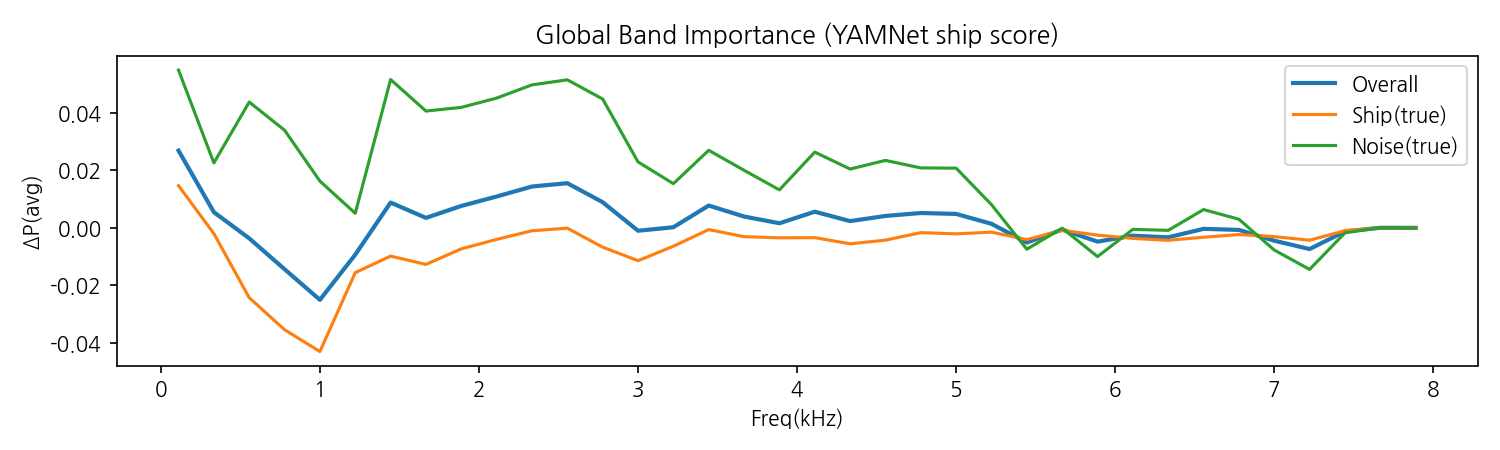


    ## 4. XAI 전시용 예제 (스펙트로그램 + 중요도 지도)

    이 섹션에서는 Part 1에서 생성한 **전시용 XAI 그림들**을 몇 장 보여줍니다.

    각 그림은 다음 정보를 포함합니다.

    - 배경: 입력 1초 구간의 **스펙트로그램 (Time–Freq–dB)**
    - 오버레이: 시간×주파수 패치 단위 occlusion을 통해 얻은 **Ship 확률 감소량(ΔP)**
      - ΔP가 클수록, 해당 패치를 가렸을 때 Ship 확률이 크게 떨어졌다는 뜻입니다.
      - 즉, 그 패치가 Ship 판정에 **중요한 패턴**으로 작용했다는 의미입니다.

    파일 이름(예: `ship_tp_00_...png`, `noise_tn_01_...png`)을 통해:

    - Ship/Noise 중 어떤 케이스인지
    - TP/TN/FP/FN 중 어디에 해당하는지

    를 함께 확인하면서 "모델이 실제로 무엇을 보고 Ship/Noise를 결정하고 있는지"를
    직관적으로 분석할 수 있습니다.
    

**noise_tn_00_t0062.png**

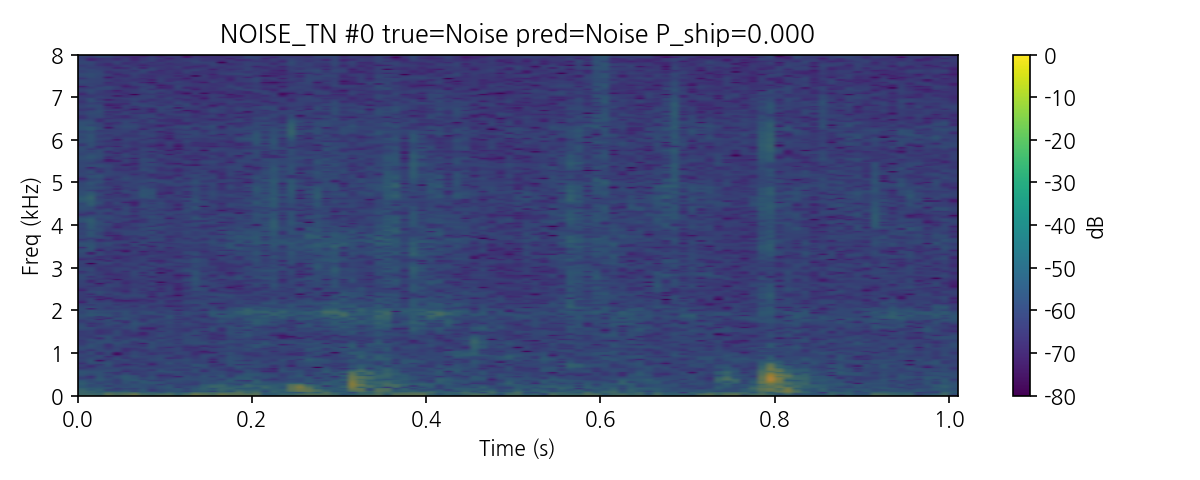

**noise_tn_01_t0045.png**

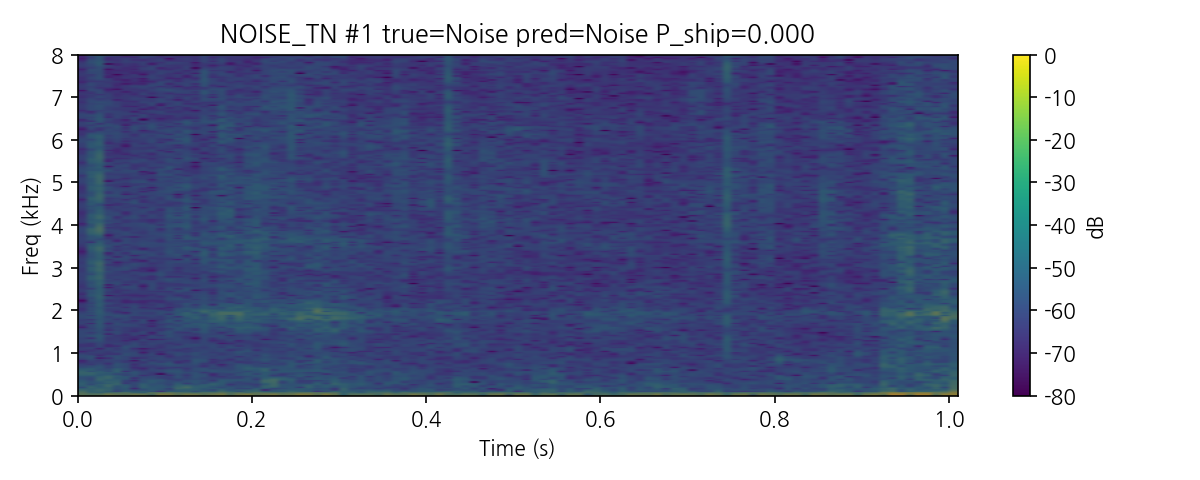

**noise_tn_02_t0109.png**

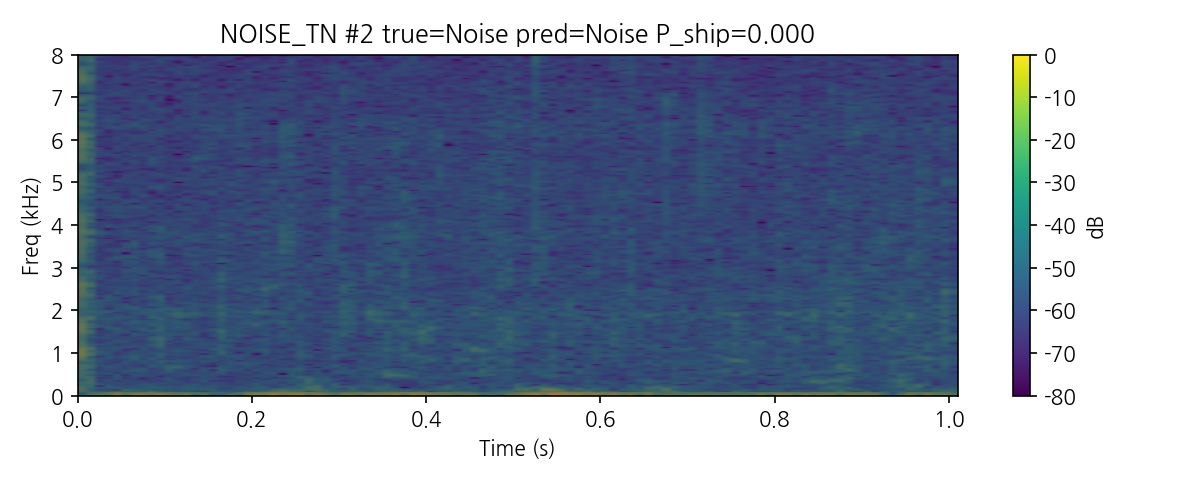

**noise_tn_03_t0119.png**

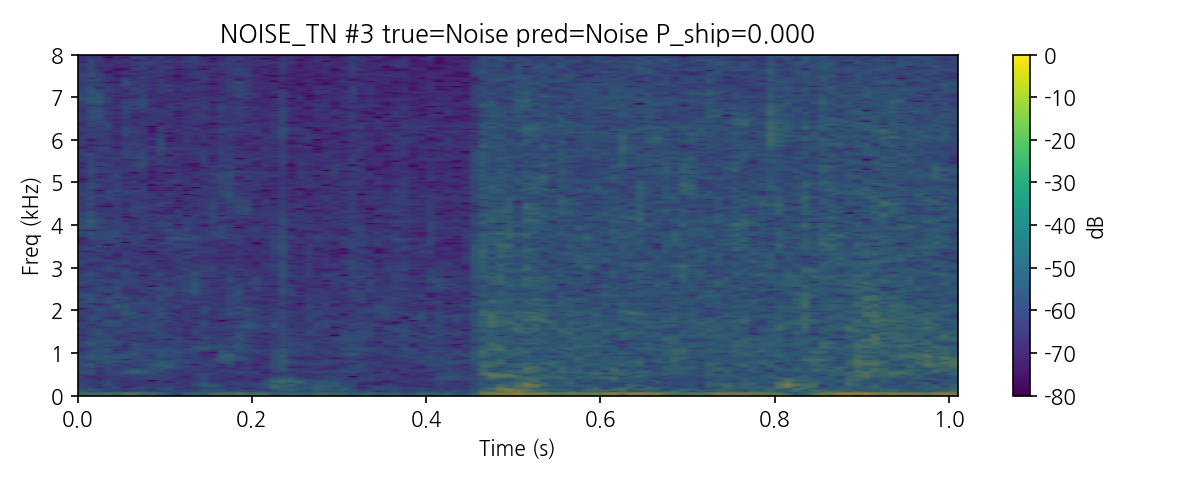

**ship_tp_00_t1676.png**

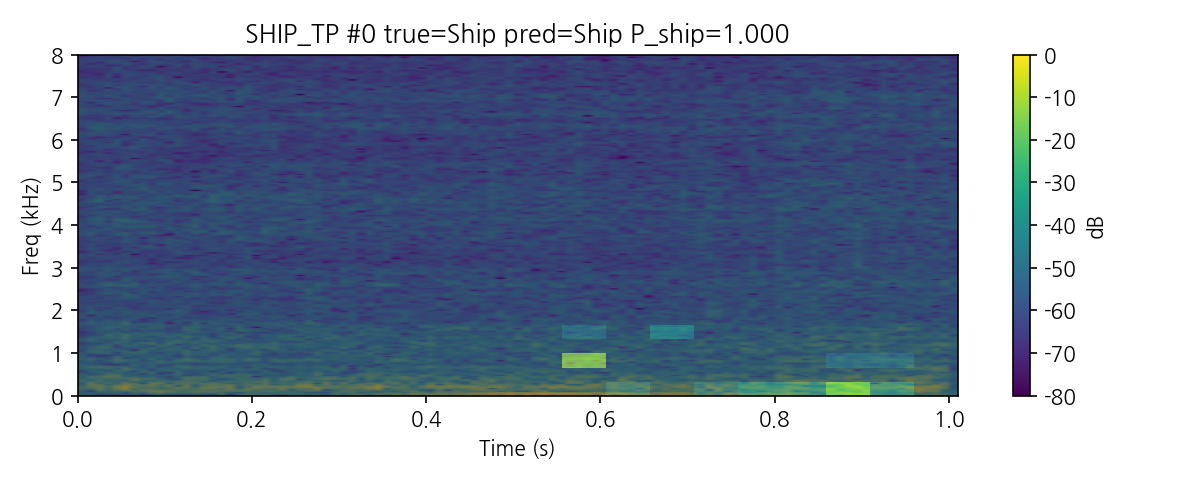

**ship_tp_01_t1667.png**

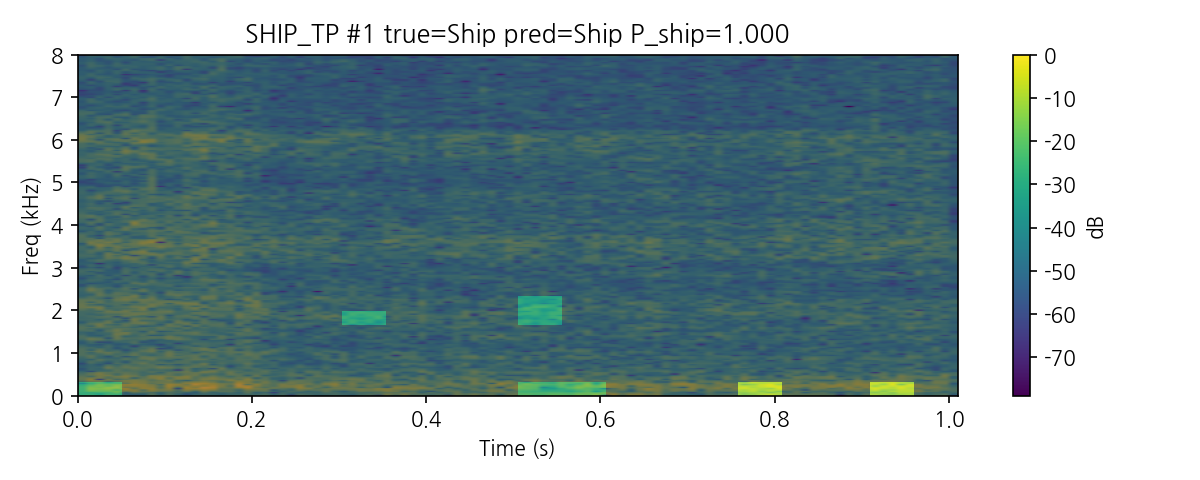


    ## 5. 평균 스펙트럼 아키타입 (Ship/Noise × TP/FN/FP/TN)

    이 섹션은 Part 2에서 계산한 **평균 스펙트럼 아키타입(mean spectrogram archetypes)** 을 보여줍니다.

    대상은 **베스트 MLP 모델**이며, 테스트 세트에서 다음 네 그룹을 구분합니다.

    1. `ship_tp` : 실제 Ship을 Ship으로 올바르게 분류한 세그먼트들
    2. `ship_fn` : 실제 Ship인데 Noise로 놓친 세그먼트들
    3. `noise_tn`: 실제 Noise를 Noise로 올바르게 분류한 세그먼트들
    4. `noise_fp`: 실제 Noise인데 Ship으로 잘못 분류한 세그먼트들

    각 그룹에 대해:

    - 여러 샘플의 스펙트로그램을 공통 크기로 정렬한 뒤
    - 세로(주파수) × 가로(시간) 방향으로 평균을 내어

    하나의 **대표 스펙트럼(아키타입)**을 만들었습니다.

    이를 통해 다음과 같은 질문에 답할 수 있습니다.

    - "모델이 잘 맞춘 Ship 샘플(ship_tp)은 어떤 전형적인 주파수 구조를 가지는가?"
    - "놓친 Ship(ship_fn)은 SNR이 특이하게 낮거나, 스펙트럼 패턴 자체가 다른가?"
    - "Noise를 Ship으로 착각하는 경우(noise_fp)는 어떤 노이즈 패턴이 문제를 일으키는가?"

    아래 이미지는 `results/part2/mean_specs/` 아래 저장된 PNG 파일들을
    `ship_tp → ship_fn → noise_tn → noise_fp` 순으로 정렬해 보여줍니다.
    

**ship_tp**

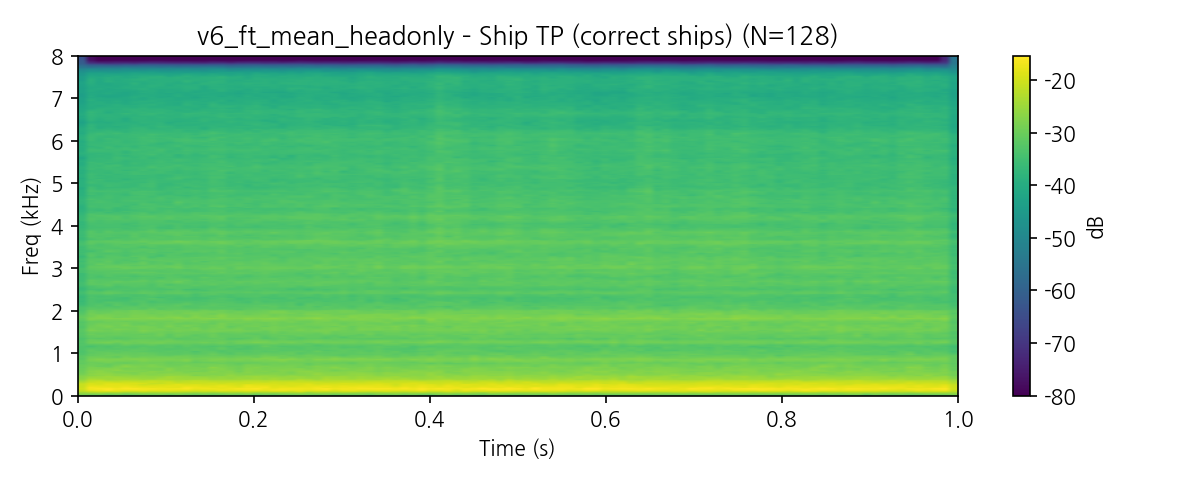

**ship_fn**

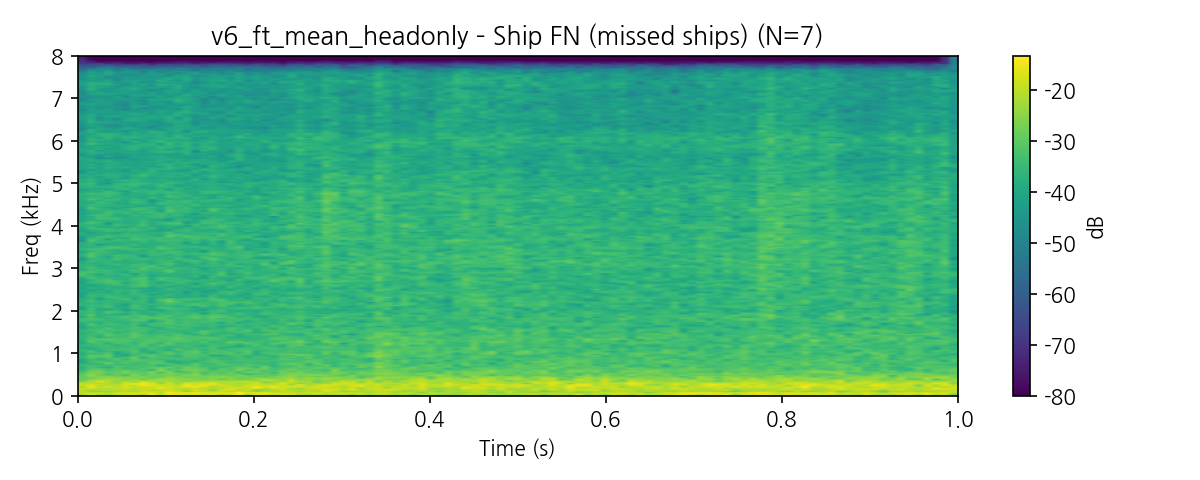

**noise_tn**

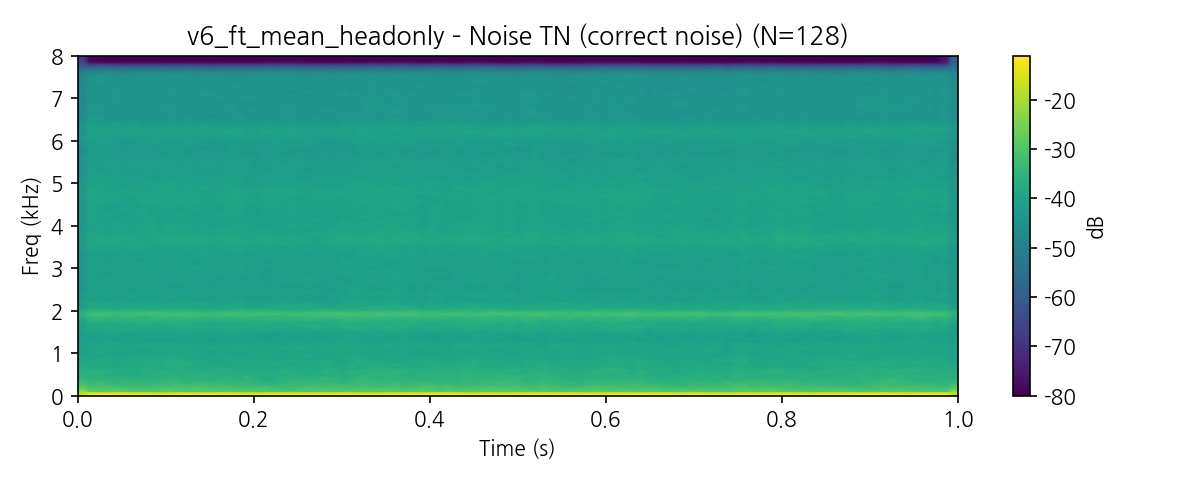

**noise_fp**

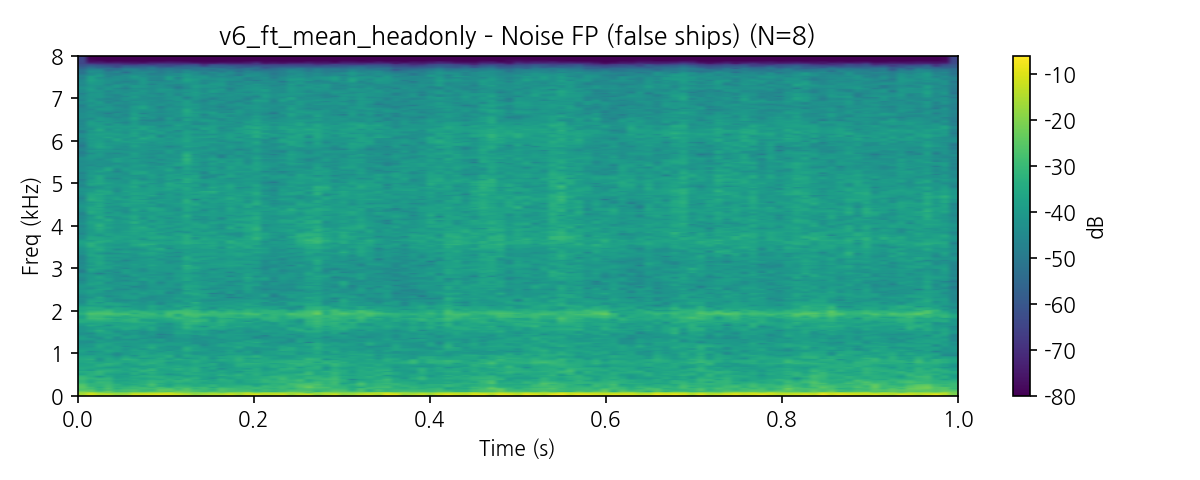


    ## 6. 베스트 MLP 모델의 TP/FN/FP/TN 대표 샘플 테이블

    마지막으로, 베스트 MLP 모델에 대해 Part 2에서 저장한 **대표 샘플 목록(exemplars)**을
    간단히 표 형태로 보여줍니다.

    각 그룹별 CSV 위치는 다음과 같습니다.

    - `results/part2/exemplars/<best_version>/tp.csv`
    - `results/part2/exemplars/<best_version>/tn.csv`
    - `results/part2/exemplars/<best_version>/fp.csv`
    - `results/part2/exemplars/<best_version>/fn.csv`

    각 테이블에는 다음 필드가 포함됩니다.

    - **file_path** : 원본 wav 파일 경로
    - **start_sec** : 해당 세그먼트의 시작 시간 (초)
    - **sr**        : 샘플레이트 (Hz)
    - **y_true_label** : 실제 레이블 (`Ship` / `Noise`)
    - **pred_label**   : 예측 레이블
    - **p_ship**       : Ship 확률

    이 정보를 이용해:

    - 특정 false positive/false negative 사례를 골라 **원본 오디오를 확인**하거나,
    - 산포가 큰 구간(예: 병목이 되는 SNR 영역)을 따로 빼서 추가 분석을 진행할 수 있습니다.
    

### TP (상위 5개 표시)

,file_path,start_sec,sr,y_true_label,pred_label,p_ship
0,/content/ShipsEar_colab/Class_C/41__19_07_13_M...,35.2,44100,Ship,Ship,1.0
1,/content/ShipsEar_colab/Class_B/21__18_07_13_l...,20.8,52734,Ship,Ship,1.0
2,/content/ShipsEar_colab/Class_B/21__18_07_13_l...,16.0,52734,Ship,Ship,1.0
3,/content/ShipsEar_colab/Class_B/21__18_07_13_l...,5.6,52734,Ship,Ship,1.0
4,/content/ShipsEar_colab/Class_B/21__18_07_13_l...,25.6,52734,Ship,Ship,1.0


### FN (상위 5개 표시)

,file_path,start_sec,sr,y_true_label,pred_label,p_ship
0,/content/ShipsEar_colab/Class_B/21__18_07_13_l...,0.0,52734,Ship,Noise,0.135010
1,/content/ShipsEar_colab/Class_A/75__23_07_13_H...,9.6,52734,Ship,Noise,0.157471
2,/content/ShipsEar_colab/Class_C/60__23_07_13_m...,8.8,52734,Ship,Noise,0.169189
3,/content/ShipsEar_colab/Class_C/41__19_07_13_M...,40.0,44100,Ship,Noise,0.187622
4,/content/ShipsEar_colab/Class_C/61__23_07_13_m...,120.8,52734,Ship,Noise,0.187988


### FP (상위 5개 표시)

,file_path,start_sec,sr,y_true_label,pred_label,p_ship
0,/content/ShipsEar_colab/Class_E/86__E__2M.wav,77.324240,52734,Noise,Ship,1.000000
1,/content/ShipsEar_colab/Class_E/86__E__2M.wav,12.724809,52734,Noise,Ship,0.995117
2,/content/ShipsEar_colab/Class_E/86__E__2M.wav,81.748191,52734,Noise,Ship,0.987305
3,/content/ShipsEar_colab/Class_E/86__E__2M.wav,83.242881,52734,Noise,Ship,0.965820
4,/content/ShipsEar_colab/Class_E/86__E__2M.wav,98.095044,52734,Noise,Ship,0.952637


### TN (상위 5개 표시)

,file_path,start_sec,sr,y_true_label,pred_label,p_ship
0,/content/ShipsEar_colab/Class_E/86__E__2M.wav,5.797353,52734,Noise,Noise,0.0
1,/content/ShipsEar_colab/Class_E/86__E__2M.wav,29.614087,52734,Noise,Noise,0.0
2,/content/ShipsEar_colab/Class_E/90__E__6H.wav,6.613449,52734,Noise,Noise,0.0
3,/content/ShipsEar_colab/Class_E/90__E__6H.wav,75.416479,52734,Noise,Noise,0.0
4,/content/ShipsEar_colab/Class_E/90__E__6H.wav,29.898034,52734,Noise,Noise,0.0


[Part 3] 리포트 생성이 완료되었습니다.


In [5]:
# ShipsEar — Part 3 v2 (Colab)
# Notebook-style rich report from saved results (Part 1 + Part 2)
#
# 사용법
# - 반드시 **Part 1 v3.x**와 **Part 2 v2**를 같은 런타임에서 먼저 실행한 뒤에 돌리세요.
# - 이 셀을 실행하면, 이미 저장된 결과 파일들을 다시 읽어와서
#   "사람이 바로 읽을 수 있는" 형태의 리포트를 노트북 출력으로 정리해 줍니다.
# - 추가 학습/추론은 전혀 하지 않으므로, 재실행 비용이 거의 없습니다.
#
# 주요 섹션
#  1) 버전 리더보드 + 베스트 모델 정보 (Part 1 요약)
#  2) 베스트 모델의 TP/TN/FP/FN 수치 (Part 2 confusion 요약)
#  3) 전역 대역 중요도(Global band importance, Hz 단위)
#  4) XAI 전시용 예제들 (스펙트로그램 + 중요도 지도)
#  5) 평균 스펙트럼 아키타입 (Ship/Noise × TP/FN/FP/TN)
#  6) 베스트 모델의 TP/FN/FP/TN 대표 샘플 테이블
#
# 각 섹션 앞에는 "이 표/그림이 의미하는 바"를 한글로 상세하게 설명하는
# Markdown 텍스트를 함께 출력하도록 구성되어 있습니다.

print("Setup (Part 3)…")

import os, json, glob, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------------------------------------------------
# 경로 및 핵심 메타데이터 로드
# ----------------------------------------------------------------------

BASE = Path("/content")
RES1 = BASE / "results" / "part1"
RES2 = BASE / "results" / "part2"
STATE = BASE / "state"

summary1_path = RES1 / "summary_part1.csv"
summary2_path = RES2 / "summary_confusion.csv"
manifest_path = STATE / "part1_manifest.json"

if not summary1_path.exists():
    raise FileNotFoundError("[Part3] results/part1/summary_part1.csv not found. 먼저 Part 1을 실행하세요.")
if not manifest_path.exists():
    raise FileNotFoundError("[Part3] state/part1_manifest.json not found. 먼저 Part 1을 실행하세요.")

summary1 = pd.read_csv(summary1_path)

try:
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)
except Exception as e:
    print("[WARN] Failed to load manifest:", e)
    manifest = {}

classes = manifest.get("classes", ["Noise", "Ship"])
CFG = manifest.get("cfg", {})
SEG_DUR = float(CFG.get("seg_dur", 1.0))

if summary2_path.exists():
    summary2 = pd.read_csv(summary2_path)
else:
    summary2 = None
    print("[WARN] results/part2/summary_confusion.csv not found. Part 2 confusion stats will be skipped.")

# ----------------------------------------------------------------------
# Helper: Part 1/2와 동일 규칙으로 best MLP 모델 선택
# ----------------------------------------------------------------------

def pick_best_mlp(df: pd.DataFrame) -> str | None:
    """Part 1/2와 동일한 기준으로 '베스트 MLP 모델' 버전명을 선택.

    규칙:
    - classifier == 'mlp' & type != 'zero' 인 행만 대상으로 함.
    - 그 중 macroF1 → bal_acc → acc 내림차순으로 정렬.
    - 첫 번째 행의 version을 반환. 없으면 None.
    """
    if "classifier" in df.columns and "type" in df.columns:
        df_mlp = df[(df["classifier"] == "mlp") & (df["type"] != "zero")].copy()
    else:
        df_mlp = df.copy()
    if df_mlp.empty:
        return None
    sort_cols = [c for c in ["macroF1", "bal_acc", "acc"] if c in df_mlp.columns]
    if sort_cols:
        df_mlp = df_mlp.sort_values(sort_cols, ascending=False)
    return str(df_mlp.iloc[0]["version"])

best_version = pick_best_mlp(summary1)

# ======================================================================
# 1. 버전 리더보드 (Part 1 metrics)
# ======================================================================

def show_leaderboard():
    # 설명 텍스트
    intro = """
    ## 1. 버전 리더보드 (Part 1 성능 요약)

    이 표는 Part 1에서 학습/평가한 **각 버전별 모델 성능**을 정리한 리더보드입니다.

    - **version**: 실험 버전 이름 (예: `v6_ft_mean_headonly`)
    - **type**:
      - `zero` : YAMNet 클래스를 직접 Ship 확률로 변환한 zero-shot 방식
      - `emb`  : YAMNet 임베딩 + 별도 분류기(logreg / MLP)
      - `ft`   : YAMNet 임베딩을 기반으로 한 head-only fine-tuning (MLP)
    - **pooling**: YAMNet frame 임베딩을 어떻게 요약했는지
      - `mean`   : 단순 평균
      - `meanstd`: 평균 + 표준편차를 concat
    - **classifier**: 임베딩 위에서 사용한 분류기 종류 (`logreg`, `mlp` 등)
    - **aug**: 학습 시 데이터 증강 여부 (`none`, `light`)
    - **acc**: (Ship/Noise 전체 기준) 일반 정확도
    - **bal_acc**: Ship/Noise 두 클래스에 대한 **balanced accuracy**
      - 클래스가 불균형일 때 성능을 더 공정하게 보는 지표입니다.
    - **macroF1**: Ship/Noise 두 클래스를 동일 가중치로 본 macro F1-score
    - **macroROC**: Ship/Noise 이진 분류 기준 ROC AUC (POS 레이블 기준)
    - **time_sec**: 해당 버전의 학습/평가에 소요된 대략적인 시간(초)

    아래 리더보드는 `macroF1 → bal_acc → acc` 순으로 내림차순 정렬되어,
    **가장 위의 행일수록 이번 실험에서 더 우수한 모델**을 의미합니다.
    """
    display(Markdown(intro))

    df = summary1.copy()
    sort_cols = [c for c in ["macroF1", "bal_acc", "acc"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols, ascending=False)

    cols = []
    for c in [
        "version",
        "type",
        "pooling",
        "classifier",
        "aug",
        "acc",
        "bal_acc",
        "macroF1",
        "macroROC",
        "time_sec",
    ]:
        if c in df.columns:
            cols.append(c)

    display(df[cols].reset_index(drop=True))

    if best_version is not None:
        display(Markdown(f"**베스트 MLP (non-zero) 모델:** `{best_version}`"))
    else:
        display(Markdown("**베스트 MLP 모델을 선택할 수 없습니다. (MLP 행이 없거나 요약 정보 부족)**"))

show_leaderboard()

# ======================================================================
# 2. 베스트 모델 confusion 통계 (Part 2)
# ======================================================================

def show_confusion_best():
    if best_version is None or summary2 is None:
        return

    intro = """
    ## 2. 베스트 MLP 모델의 TP/TN/FP/FN 통계 (Part 2 기준)

    여기서는 Part 2에서 계산한 **베스트 MLP 모델**의 confusion 통계를 보여줍니다.

    - **n**: 테스트 세그먼트 전체 개수
    - **n_ship_true**: 실제 Ship(양성) 세그먼트 개수
    - **n_noise_true**: 실제 Noise(음성) 세그먼트 개수
    - **tp (True Positive)**: 실제 Ship을 Ship으로 맞춘 개수
    - **tn (True Negative)**: 실제 Noise를 Noise로 맞춘 개수
    - **fp (False Positive)**: 실제 Noise인데 Ship으로 잘못 판단한 개수
    - **fn (False Negative)**: 실제 Ship인데 Noise로 놓친 개수
    - **acc**: 전체 정확도
    - **bal_acc**: Ship/Noise 각각의 정확도를 평균낸 balanced accuracy

    이 표를 통해:

    - 모델이 **Ship을 놓치는 경향이 있는지(fn)**,
    - 혹은 **Noise를 Ship으로 오판하는 경향이 있는지(fp)**

    를 직관적으로 확인할 수 있습니다.
    """
    display(Markdown(intro))

    row = summary2[summary2["version"] == best_version]
    if row.empty:
        display(Markdown(f"Part 2 summary에서 `{best_version}`에 해당하는 행을 찾을 수 없습니다."))
        return

    r = row.iloc[0]
    df = pd.DataFrame(
        {
            "metric": [
                "n",
                "n_ship_true",
                "n_noise_true",
                "tp",
                "tn",
                "fp",
                "fn",
                "acc",
                "bal_acc",
            ],
            "value": [
                int(r["n"]),
                int(r["n_ship_true"]),
                int(r["n_noise_true"]),
                int(r["tp"]),
                int(r["tn"]),
                int(r["fp"]),
                int(r["fn"]),
                float(r["acc"]),
                float(r["bal_acc"]),
            ],
        }
    )
    display(df)

show_confusion_best()

# ======================================================================
# 3. Global band importance (Hz)
# ======================================================================

def show_global_band_importance():
    intro = """
    ## 3. Global band importance (Hz 단위)

    이 섹션은 Part 1에서 계산한 **전역 주파수 대역 중요도(Global band importance)**를 보여줍니다.

    계산 개념(요약):

    1. 여러 샘플을 랜덤하게 선택합니다 (예: N=300).
    2. 각 샘플에 대해, 여러 주파수 대역(예: 0–250 Hz, 250–500 Hz …)을 하나씩 가려보면서
       Ship 확률이 얼마나 떨어지는지(ΔP)를 측정합니다.
    3. 모든 샘플에 대해 해당 대역의 ΔP를 평균 내어, 그 대역의 중요도 스코어로 사용합니다.

    따라서 **importance 값이 클수록**, 해당 대역을 가렸을 때 Ship 확률이 많이 떨어졌다는 의미이므로,
    모델이 Ship/Noise 구분 시 **그 대역을 더 강하게 활용하고 있다**고 해석할 수 있습니다.
    """
    display(Markdown(intro))

    csv_path = RES1 / "global_band_importance.csv"
    png_path = RES1 / "global_band_importance.png"

    if not csv_path.exists():
        display(Markdown("`global_band_importance.csv` 파일이 없어 이 섹션은 건너뜁니다."))
        return

    gb = pd.read_csv(csv_path)

    if "importance" in gb.columns:
        gb_top = gb.sort_values("importance", ascending=False).head(10)
        cols = [c for c in ["freq_low_Hz", "freq_high_Hz", "importance"] if c in gb_top.columns]
        display(Markdown("**중요도가 높은 상위 10개 대역:**"))
        display(gb_top[cols].reset_index(drop=True))
    else:
        display(Markdown("Global band CSV는 존재하지만 `importance` 컬럼을 찾지 못했습니다."))

    if png_path.exists():
        display(Markdown("**전역 대역 중요도 플롯:**"))
        display(Image(filename=str(png_path)))

show_global_band_importance()

# ======================================================================
# 4. XAI exhibits — 스펙트로그램 + 중요도 지도 (Part 1)
# ======================================================================

def show_exhibits(n_max: int = 6):
    intro = """
    ## 4. XAI 전시용 예제 (스펙트로그램 + 중요도 지도)

    이 섹션에서는 Part 1에서 생성한 **전시용 XAI 그림들**을 몇 장 보여줍니다.

    각 그림은 다음 정보를 포함합니다.

    - 배경: 입력 1초 구간의 **스펙트로그램 (Time–Freq–dB)**
    - 오버레이: 시간×주파수 패치 단위 occlusion을 통해 얻은 **Ship 확률 감소량(ΔP)**
      - ΔP가 클수록, 해당 패치를 가렸을 때 Ship 확률이 크게 떨어졌다는 뜻입니다.
      - 즉, 그 패치가 Ship 판정에 **중요한 패턴**으로 작용했다는 의미입니다.

    파일 이름(예: `ship_tp_00_...png`, `noise_tn_01_...png`)을 통해:

    - Ship/Noise 중 어떤 케이스인지
    - TP/TN/FP/FN 중 어디에 해당하는지

    를 함께 확인하면서 "모델이 실제로 무엇을 보고 Ship/Noise를 결정하고 있는지"를
    직관적으로 분석할 수 있습니다.
    """
    display(Markdown(intro))

    ex_dir = RES1 / "exhibits"
    if not ex_dir.exists():
        display(Markdown("`results/part1/exhibits/` 디렉토리를 찾을 수 없습니다. (Part 1 XAI 전시용 이미지가 없을 수 있음)"))
        return

    imgs = sorted(glob.glob(str(ex_dir / "*.png")))
    if not imgs:
        display(Markdown("`results/part1/exhibits` 아래에 PNG 파일이 없습니다."))
        return

    imgs = imgs[:n_max]
    for p in imgs:
        base = os.path.basename(p)
        display(Markdown(f"**{base}**"))
        display(Image(filename=p))

show_exhibits(n_max=6)

# ======================================================================
# 5. 평균 스펙트럼 아키타입 (Part 2)
# ======================================================================

def show_mean_specs():
    intro = """
    ## 5. 평균 스펙트럼 아키타입 (Ship/Noise × TP/FN/FP/TN)

    이 섹션은 Part 2에서 계산한 **평균 스펙트럼 아키타입(mean spectrogram archetypes)** 을 보여줍니다.

    대상은 **베스트 MLP 모델**이며, 테스트 세트에서 다음 네 그룹을 구분합니다.

    1. `ship_tp` : 실제 Ship을 Ship으로 올바르게 분류한 세그먼트들
    2. `ship_fn` : 실제 Ship인데 Noise로 놓친 세그먼트들
    3. `noise_tn`: 실제 Noise를 Noise로 올바르게 분류한 세그먼트들
    4. `noise_fp`: 실제 Noise인데 Ship으로 잘못 분류한 세그먼트들

    각 그룹에 대해:

    - 여러 샘플의 스펙트로그램을 공통 크기로 정렬한 뒤
    - 세로(주파수) × 가로(시간) 방향으로 평균을 내어

    하나의 **대표 스펙트럼(아키타입)**을 만들었습니다.

    이를 통해 다음과 같은 질문에 답할 수 있습니다.

    - "모델이 잘 맞춘 Ship 샘플(ship_tp)은 어떤 전형적인 주파수 구조를 가지는가?"
    - "놓친 Ship(ship_fn)은 SNR이 특이하게 낮거나, 스펙트럼 패턴 자체가 다른가?"
    - "Noise를 Ship으로 착각하는 경우(noise_fp)는 어떤 노이즈 패턴이 문제를 일으키는가?"

    아래 이미지는 `results/part2/mean_specs/` 아래 저장된 PNG 파일들을
    `ship_tp → ship_fn → noise_tn → noise_fp` 순으로 정렬해 보여줍니다.
    """
    display(Markdown(intro))

    if best_version is None:
        display(Markdown("베스트 버전이 정의되지 않아 mean spectrogram을 불러올 수 없습니다."))
        return

    mean_dir = RES2 / "mean_specs"
    if not mean_dir.exists():
        display(Markdown("`results/part2/mean_specs/` 디렉토리가 없습니다. 먼저 Part 2를 실행해야 합니다."))
        return

    pattern = f"mean_spec_{best_version}_*.png"
    files = sorted(glob.glob(str(mean_dir / pattern)))
    if not files:
        display(Markdown(f"`{best_version}`에 해당하는 mean spectrogram PNG 파일을 찾지 못했습니다."))
        return

    # ship_tp → ship_fn → noise_tn → noise_fp 순으로 정렬
    order_keys = ["ship_tp", "ship_fn", "noise_tn", "noise_fp"]
    ordered: list[tuple[str, str]] = []
    for key in order_keys:
        for p in files:
            if p.endswith(f"_{key}.png"):
                ordered.append((key, p))

    used = {p for _, p in ordered}
    for p in files:
        if p not in used:
            base = os.path.splitext(os.path.basename(p))[0]
            ordered.append((base, p))

    for label, p in ordered:
        display(Markdown(f"**{label}**"))
        display(Image(filename=p))

show_mean_specs()

# ======================================================================
# 6. 베스트 모델 TP/FN/FP/TN 대표 샘플 테이블 (Part 2)
# ======================================================================

def show_exemplar_tables(max_rows: int = 5):
    intro = """
    ## 6. 베스트 MLP 모델의 TP/FN/FP/TN 대표 샘플 테이블

    마지막으로, 베스트 MLP 모델에 대해 Part 2에서 저장한 **대표 샘플 목록(exemplars)**을
    간단히 표 형태로 보여줍니다.

    각 그룹별 CSV 위치는 다음과 같습니다.

    - `results/part2/exemplars/<best_version>/tp.csv`
    - `results/part2/exemplars/<best_version>/tn.csv`
    - `results/part2/exemplars/<best_version>/fp.csv`
    - `results/part2/exemplars/<best_version>/fn.csv`

    각 테이블에는 다음 필드가 포함됩니다.

    - **file_path** : 원본 wav 파일 경로
    - **start_sec** : 해당 세그먼트의 시작 시간 (초)
    - **sr**        : 샘플레이트 (Hz)
    - **y_true_label** : 실제 레이블 (`Ship` / `Noise`)
    - **pred_label**   : 예측 레이블
    - **p_ship**       : Ship 확률

    이 정보를 이용해:

    - 특정 false positive/false negative 사례를 골라 **원본 오디오를 확인**하거나,
    - 산포가 큰 구간(예: 병목이 되는 SNR 영역)을 따로 빼서 추가 분석을 진행할 수 있습니다.
    """
    display(Markdown(intro))

    if best_version is None:
        display(Markdown("베스트 버전이 정의되지 않아 exemplar 테이블을 불러올 수 없습니다."))
        return

    ex_root = RES2 / "exemplars" / best_version
    if not ex_root.exists():
        display(Markdown(f"`{best_version}`에 대한 exemplar 디렉토리를 찾지 못했습니다. (expected: `{ex_root}`)"))
        return

    groups = ["tp", "fn", "fp", "tn"]
    for g in groups:
        path = ex_root / f"{g}.csv"
        if not path.exists():
            continue
        try:
            df = pd.read_csv(path)
        except Exception as e:
            display(Markdown(f"`{path.name}` 파일을 읽는 중 오류 발생: {e}"))
            continue
        if df.empty:
            continue
        display(Markdown(f"### {g.upper()} (상위 {max_rows}개 표시)"))
        cols = [
            "file_path",
            "start_sec",
            "sr",
            "y_true_label",
            "pred_label",
            "p_ship",
        ]
        cols = [c for c in cols if c in df.columns]
        display(df[cols].head(max_rows))

show_exemplar_tables(max_rows=5)

print("[Part 3] 리포트 생성이 완료되었습니다.")

# ----------------------------------------------------------------------
# CHANGELOG
# ----------------------------------------------------------------------
# v2
# - v1 구조를 유지하면서 각 섹션 앞에 상세한 한글 설명(Markdown)을 추가.
# - Part 1/2의 결과를 처음 보는 사람도 바로 이해할 수 있도록, 지표/그림의 의미를
#   단계별로 서술식으로 정리.
# - 타입 힌트 및 예외 처리 메시지를 약간 보강.
